In [256]:
# Import useful Python libraries.

from collections import deque
import random
import time
import calendar
import datetime
from datetime import date, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, callbacks, optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer


from scipy.interpolate import griddata

# 1. Data Acquisition & Cleaning

In [257]:
df_raw = pd.read_csv("./Data/AAPL Options/aapl_2016_2020.csv")
print(df_raw)

C:\Users\jonah\AppData\Local\Temp\ipykernel_49564\77478603.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("./Data/AAPL Options/aapl_2016_2020.csv")


         [QUOTE_UNIXTIME]   [QUOTE_READTIME]  [QUOTE_DATE]  \
0              1546462800   2019-01-02 16:00    2019-01-02   
1              1546462800   2019-01-02 16:00    2019-01-02   
2              1546462800   2019-01-02 16:00    2019-01-02   
3              1546462800   2019-01-02 16:00    2019-01-02   
4              1546462800   2019-01-02 16:00    2019-01-02   
...                   ...                ...           ...   
1015347        1490990400   2017-03-31 16:00    2017-03-31   
1015348        1490990400   2017-03-31 16:00    2017-03-31   
1015349        1490990400   2017-03-31 16:00    2017-03-31   
1015350        1490990400   2017-03-31 16:00    2017-03-31   
1015351        1490990400   2017-03-31 16:00    2017-03-31   

          [QUOTE_TIME_HOURS]   [UNDERLYING_LAST]  [EXPIRE_DATE]  \
0                       16.0              157.92     2019-01-04   
1                       16.0              157.92     2019-01-04   
2                       16.0              157.92     2

Use info() method to look at the raw data.

In [258]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015352 entries, 0 to 1015351
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   [QUOTE_UNIXTIME]        1015352 non-null  int64  
 1    [QUOTE_READTIME]       1015352 non-null  object 
 2    [QUOTE_DATE]           1015352 non-null  object 
 3    [QUOTE_TIME_HOURS]     1015352 non-null  float64
 4    [UNDERLYING_LAST]      1015352 non-null  float64
 5    [EXPIRE_DATE]          1015352 non-null  object 
 6    [EXPIRE_UNIX]          1015352 non-null  int64  
 7    [DTE]                  1015352 non-null  float64
 8    [C_DELTA]              1015352 non-null  object 
 9    [C_GAMMA]              1015352 non-null  object 
 10   [C_VEGA]               1015352 non-null  object 
 11   [C_THETA]              1015352 non-null  object 
 12   [C_RHO]                1015352 non-null  object 
 13   [C_IV]                 1015352 non-null  object 
 14   [

Clean the column names using list comprehension

In [259]:
columns = df_raw.columns
columns = [s.replace('[', '') for s in columns]
columns = [s.replace(']', '') for s in columns]
columns = [s.replace(' ', '') for s in columns]
df_raw.columns = columns

Remove set the index to the quote_date as all times are 16:00. Then remove the excess columns.

In [260]:
date_columns = ['QUOTE_TIME_HOURS','QUOTE_READTIME','EXPIRE_DATE']
df_raw.set_index('QUOTE_DATE', inplace=True)
numeric_cols = df_raw.columns.to_list()
numeric_cols.remove('QUOTE_READTIME')
numeric_cols.remove('QUOTE_TIME_HOURS')
numeric_cols.remove('EXPIRE_DATE')
numeric_cols

['QUOTE_UNIXTIME',
 'UNDERLYING_LAST',
 'EXPIRE_UNIX',
 'DTE',
 'C_DELTA',
 'C_GAMMA',
 'C_VEGA',
 'C_THETA',
 'C_RHO',
 'C_IV',
 'C_VOLUME',
 'C_LAST',
 'C_SIZE',
 'C_BID',
 'C_ASK',
 'STRIKE',
 'P_BID',
 'P_ASK',
 'P_SIZE',
 'P_LAST',
 'P_DELTA',
 'P_GAMMA',
 'P_VEGA',
 'P_THETA',
 'P_RHO',
 'P_IV',
 'P_VOLUME',
 'STRIKE_DISTANCE',
 'STRIKE_DISTANCE_PCT']

Then convert the rest of the data to numerical:

In [261]:
numeric_df = df_raw.drop(columns=date_columns)

for i in numeric_cols:
    numeric_df[i] = pd.to_numeric(numeric_df[i], errors='coerce')
    
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015352 entries,  2019-01-02 to  2017-03-31
Data columns (total 29 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   QUOTE_UNIXTIME       1015352 non-null  int64  
 1   UNDERLYING_LAST      1015352 non-null  float64
 2   EXPIRE_UNIX          1015352 non-null  int64  
 3   DTE                  1015352 non-null  float64
 4   C_DELTA              1015336 non-null  float64
 5   C_GAMMA              1015336 non-null  float64
 6   C_VEGA               1015336 non-null  float64
 7   C_THETA              1015336 non-null  float64
 8   C_RHO                1015336 non-null  float64
 9   C_IV                 946065 non-null   float64
 10  C_VOLUME             690632 non-null   float64
 11  C_LAST               1014138 non-null  float64
 12  C_SIZE               0 non-null        float64
 13  C_BID                1014137 non-null  float64
 14  C_ASK                1014137 non-null  fl

Now remove C_SIZE and P_SIZE, and drop split the data across puts and calls.

In [262]:

# --- 1) Define universal vs. call vs. put columns ---
universal_cols = [
    'QUOTE_UNIXTIME', 'UNDERLYING_LAST', 'EXPIRE_UNIX', 
    'DTE', 'STRIKE', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'
]

call_cols = [
    'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO',
    'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 'C_ASK'
]

put_cols = [
    'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO',
    'P_IV', 'P_VOLUME', 'P_LAST', 'P_BID', 'P_ASK'
]

# --- 2) Create call_df ---
call_df = df_raw[universal_cols + call_cols].copy()

# OPTIONAL: Rename call columns to remove the "C_" prefix
call_rename_dict = {
    'C_DELTA': 'DELTA',
    'C_GAMMA': 'GAMMA',
    'C_VEGA':  'VEGA',
    'C_THETA': 'THETA',
    'C_RHO':   'RHO',
    'C_IV':    'IV',
    'C_VOLUME':'VOLUME',
    'C_LAST':  'LAST',
    'C_BID':   'BID',
    'C_ASK':   'ASK'
}
call_df.rename(columns=call_rename_dict, inplace=True)

# --- 3) Create put_df ---
put_df = df_raw[universal_cols + put_cols].copy()

# OPTIONAL: Rename put columns to remove the "P_" prefix
put_rename_dict = {
    'P_DELTA': 'DELTA',
    'P_GAMMA': 'GAMMA',
    'P_VEGA':  'VEGA',
    'P_THETA': 'THETA',
    'P_RHO':   'RHO',
    'P_IV':    'IV',
    'P_VOLUME':'VOLUME',
    'P_LAST':  'LAST',
    'P_BID':   'BID',
    'P_ASK':   'ASK'
}
put_df.rename(columns=put_rename_dict, inplace=True)

# Now call_df and put_df have similar, consistent column names for each option type


Now combine them with a P/C column and sort by date:

Implement Log moneyness as a secondary measure alongside strike

In [263]:
call_df['OPTION_TYPE'] = 'C'
put_df['OPTION_TYPE'] = 'P'
combined_df = pd.DataFrame()
combined_df = pd.concat([call_df, put_df], ignore_index=True)
combined_df = combined_df.sort_values(by = 'QUOTE_UNIXTIME')
combined_df['LOG_MONEYNESS'] = np.log(combined_df['STRIKE'] / combined_df['UNDERLYING_LAST'])
combined_df

QUOTE_UNIXTIME  UNDERLYING_LAST  EXPIRE_UNIX     DTE  STRIKE  \
1773182      1451941200           105.35   1452286800    4.00    60.0   
1773364      1451941200           105.35   1452891600   11.00   140.0   
1773365      1451941200           105.35   1452891600   11.00   145.0   
1773366      1451941200           105.35   1452891600   11.00   150.0   
1773367      1451941200           105.35   1452891600   11.00   155.0   
...                 ...              ...          ...     ...     ...   
1186408      1609448400           132.60   1626465600  196.96   145.0   
1186409      1609448400           132.60   1626465600  196.96   150.0   
1186410      1609448400           132.60   1626465600  196.96   155.0   
1186404      1609448400           132.60   1626465600  196.96   125.0   
1186146      1609448400           132.60   1613768400   50.00   140.0   

         STRIKE_DISTANCE  STRIKE_DISTANCE_PCT    DELTA    GAMMA     VEGA  \
1773182             45.3                0.430 -0.00156  0.00024  0.00063   
1773364             34.7                0.329 -0.90221  0.00055  0.02831   
1773365             39.7                0.376     -1.0      0.0      0.0   
1773366             44.7                0.424 -0.88498  0.00039  0.03031   
1773367             49.7                0.471 -0.87726  0.00013  0.03195   
...                  ...                  ...      ...      ...      ...   
1186408             12.4                0.094 -0.58275  0.01112  0.37933   
1186409             17.4                0.131 -0.63359  0.01073  0.36582   
1186410             22.4                0.169 -0.67026  0.00986  0.34991   
1186404              7.6                0.057 -0.36121  0.01057  0.36549   
1186146              7.4                0.056 -0.63086  0.02064  0.18664   

           THETA      RHO          IV       VOLUME   LAST    BID    ASK  \
1773182 -0.00743 -0.00007    1.689400                 0.0    0.0   0.02   
1773364 -0.04968 -0.01393    0.925300     7.000000  36.96  34.55  34.84   
1773365      0.0      0.0   -0.000330                 0.0   39.5  39.81   
1773366 -0.04981 -0.01404    1.185120    80.000000   47.2  44.56  44.85   
1773367 -0.02519 -0.01435    1.307810                 0.0  49.49  49.85   
...          ...      ...         ...          ...    ...    ...    ...   
1186408 -0.03338 -0.47002    0.351760     1.000000   21.2   21.2  21.44   
1186409 -0.03201 -0.50184    0.350800    11.000000  24.85  24.65   24.9   
1186410 -0.03175 -0.52425    0.360590     1.000000  29.12  28.19  29.56   
1186404 -0.03325 -0.29928    0.362050    34.000000  10.11  10.11  10.26   
1186146 -0.07006  -0.1334    0.367070   166.000000  11.67   11.8   11.9   

        OPTION_TYPE  LOG_MONEYNESS  
1773182           P      -0.562944  
1773364           P       0.284354  
1773365           P       0.319446  
1773366           P       0.353347  
1773367           P       0.386137  
...             ...            ...  
1186408           P       0.089397  
1186409           P       0.123298  
1186410           P       0.156088  
1186404           P      -0.059023  
1186146           P       0.054305  

[2030704 rows x 19 columns]

In [264]:
cols = combined_df.columns.drop('OPTION_TYPE')
for i in cols:
    combined_df[i] = pd.to_numeric(combined_df[i], errors='coerce')
    
combined_df['OPTION_TYPE'] = combined_df['OPTION_TYPE'].astype(str)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2030704 entries, 1773182 to 1186146
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   QUOTE_UNIXTIME       int64  
 1   UNDERLYING_LAST      float64
 2   EXPIRE_UNIX          int64  
 3   DTE                  float64
 4   STRIKE               float64
 5   STRIKE_DISTANCE      float64
 6   STRIKE_DISTANCE_PCT  float64
 7   DELTA                float64
 8   GAMMA                float64
 9   VEGA                 float64
 10  THETA                float64
 11  RHO                  float64
 12  IV                   float64
 13  VOLUME               float64
 14  LAST                 float64
 15  BID                  float64
 16  ASK                  float64
 17  OPTION_TYPE          object 
 18  LOG_MONEYNESS        float64
dtypes: float64(16), int64(2), object(1)
memory usage: 309.9+ MB


 Perfom some basic EDA on extreme values

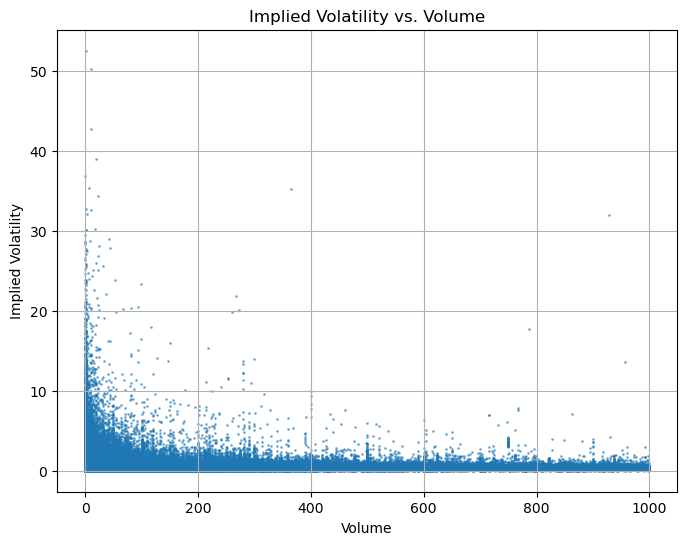

In [265]:
# Extract the relevant columns
x = combined_df['VOLUME']  # Days to Expiry
y = combined_df['IV']   # Implied Volatility

# Create the plot
plt.figure(figsize=(8, 6))   # Adjust the figure size as needed
plt.scatter(x, y, marker='o', s = 1, alpha = 0.5)   # Add markers to highlight data points
plt.xlabel('Volume')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Volume')
plt.grid(True)

# Display the plot
plt.show()

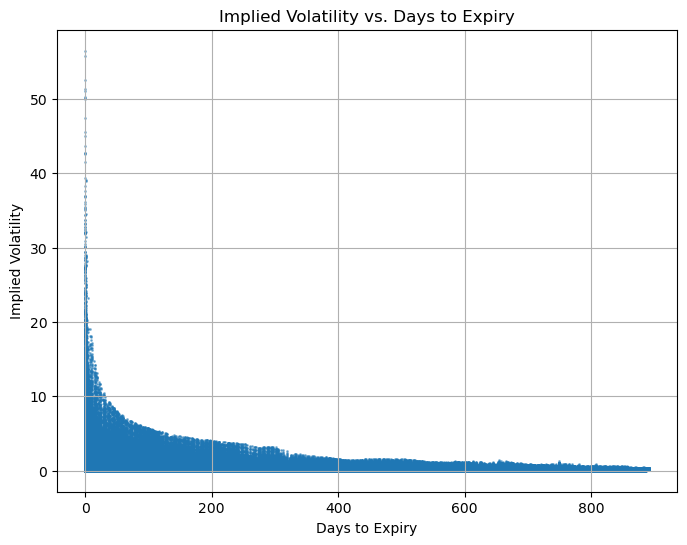

In [266]:
# Extract the relevant columns
x = combined_df['DTE']  # Days to Expiry
y = combined_df['IV']   # Implied Volatility

# Create the plot
plt.figure(figsize=(8, 6))   # Adjust the figure size as needed
plt.scatter(x, y, marker='o', s = 1, alpha = 0.5)   # Add markers to highlight data points
plt.xlabel('Days to Expiry')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Days to Expiry')
plt.grid(True)

# Display the plot
plt.show()

In [267]:
# Sort by time and set as index
combined_df['Date'] = pd.to_datetime(combined_df['QUOTE_UNIXTIME'], unit='s')
combined_df = combined_df.set_index('Date').sort_index()
unfiltered_df = combined_df.copy()

Filter out nonsense, there is extreme IV for options with very low DTE 

In [268]:
count_IV = (unfiltered_df['IV'] < 0).sum()
count_DTE = (unfiltered_df['DTE'] < 0).sum()
nan_count = unfiltered_df['IV'].isna().sum()
count_vol = (unfiltered_df['VOLUME'] < 5).sum()
count_days = (unfiltered_df['DTE'] < 7).sum()
count_IV_max = (unfiltered_df['IV'] > 3).sum()
print(count_IV, count_DTE, nan_count, count_vol, count_days, count_IV_max)

27870 0 130996 484968 159978 23472


In [269]:
combined_df = combined_df[combined_df['IV'] > 0.01]
combined_df = combined_df[combined_df['VOLUME'] >= 5]
combined_df = combined_df[combined_df['IV'] <= 3]

Now to ensure good feautre selection we compare the corrleation betweenall elements of the df

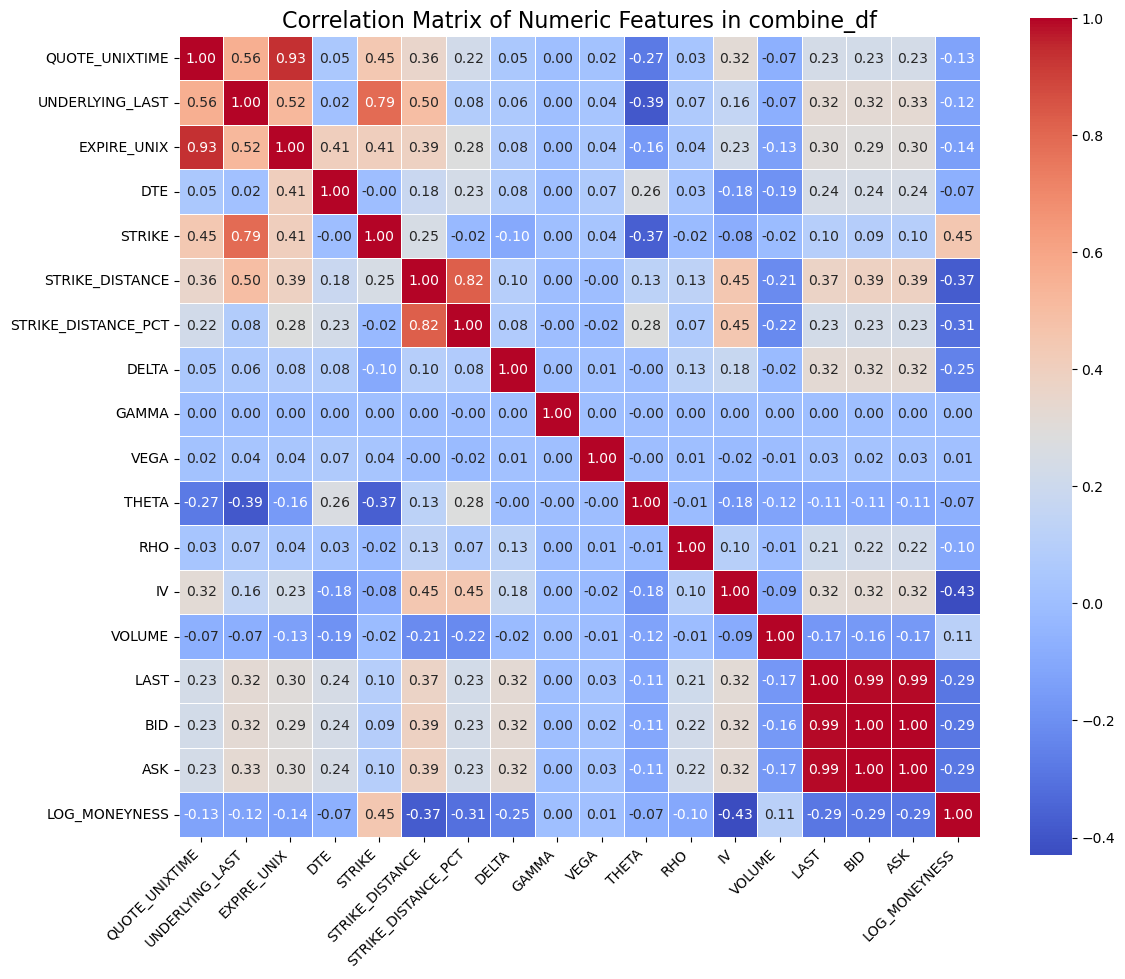

In [270]:
# Filter numeric columns
combined_df_numeric = combined_df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = combined_df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features in combine_df", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We find that: LAST, BID, ASK are almost idetically correlated and have almost idetical effect on IV, so we take a mid price of bid and ask and remove the rest, we do this as there is a possiblity that that last price may be stale (last trade was a while ago).

Then we focus on features with the greatest correlation (abs > 0.4) and features fundamental to the problem (DTE, STIKE, UNDERLYING_LAST).

To perform some feature enginerinng we take STRKE_DISTACE as a measure of STRIKE - UNDERLYING_LAST and STRIKE_DISTANCE_PCT as a measure of (STRIKE - UNDERLYING_LAST) / UNDERLYING_LAST
we will keep both despite their collinearity as our neutal networks should be able to handle them


In [271]:
combined_df['MID_PRICE'] = (combined_df['BID'] + combined_df['ASK']) / 2
combined_df.drop(columns=['QUOTE_UNIXTIME', 'EXPIRE_UNIX'], inplace=True)

We can remove QUOTE_UNIXTIME and EXPIRE_UNIX as DTE and Date index combine to serve the same purpose. Also UNIX time is very bad for models

In [272]:
combined_df.drop(columns=['LAST', 'BID', 'ASK', 'GAMMA', 'VEGA', 'RHO', 'DELTA', 'THETA'], inplace=True)

Drop any NAN colums for our features

In [273]:
combined_df.dropna(subset = ['UNDERLYING_LAST', 'DTE', 'STRIKE', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'VOLUME', 'MID_PRICE', 'LOG_MONEYNESS', 'OPTION_TYPE'], inplace = True)
combined_df.shape

(825035, 10)

Split the data, note after August 28, 2020 apple stock split. (Announced on 30th of July)

In [274]:
combined_df = combined_df[combined_df.index <= datetime.datetime(2020, 7, 30)] # exclude anything on/after July 30, 2020 as so not to effect the EDA


# TRAIN_START = "2019-12-01"
# TRAIN_CUTOFF   = "2020-01-01"
# VALID_CUTOFF   = "2020-01-15"
# END_DATE         = "2020-01-30"




TRAIN_START = "2016-01-04"
TRAIN_CUTOFF   = "2020-01-30"
VALID_CUTOFF   = "2020-04-30"
END_DATE         = "2020-07-30" # this gives about an 80-10-10 split across the whole set


# Train, validation, test splits:
train_df = combined_df[
    (combined_df.index > TRAIN_START) & 
    (combined_df.index < TRAIN_CUTOFF)
]

valid_df = combined_df[
    (combined_df.index >= TRAIN_CUTOFF) & 
    (combined_df.index < VALID_CUTOFF)
]

test_df  = combined_df[
    (combined_df.index >= VALID_CUTOFF) &
    (combined_df.index < END_DATE)
]


#Verify the number of rows in each split and date ranges

print("Train set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("Test set size:", len(test_df))

print("Train date range:", train_df.index.min(), "->", train_df.index.max())
print("Valid date range:", valid_df.index.min(), "->", valid_df.index.max())
print("Test date range:", test_df.index.min(),  "->", test_df.index.max())




Train set size: 561284
Validation set size: 65233
Test set size: 66313
Train date range: 2016-01-04 21:00:00 -> 2020-01-29 21:00:00
Valid date range: 2020-01-30 21:00:00 -> 2020-04-29 20:00:00
Test date range: 2020-04-30 20:00:00 -> 2020-07-29 20:00:00


# 2. Exploratory Data Analysis


In [275]:
test_df

UNDERLYING_LAST     DTE  STRIKE  STRIKE_DISTANCE  \
Date                                                                    
2020-04-30 20:00:00           293.95  169.00   440.0            146.1   
2020-04-30 20:00:00           293.95  232.04   145.0            148.9   
2020-04-30 20:00:00           293.95  232.04   180.0            113.9   
2020-04-30 20:00:00           293.95  232.04   200.0             93.9   
2020-04-30 20:00:00           293.95  232.04   240.0             53.9   
...                              ...     ...     ...              ...   
2020-07-29 20:00:00           380.27   30.00   480.0             99.7   
2020-07-29 20:00:00           380.27   30.00   495.0            114.7   
2020-07-29 20:00:00           380.27   30.00   550.0            169.7   
2020-07-29 20:00:00           380.27   30.00   500.0            119.7   
2020-07-29 20:00:00           380.27   30.00   367.5             12.8   

                     STRIKE_DISTANCE_PCT       IV  VOLUME OPTION_TYPE  \
Date                                                                    
2020-04-30 20:00:00                0.497  0.30316   128.0           C   
2020-04-30 20:00:00                0.507  0.69020     5.0           C   
2020-04-30 20:00:00                0.388  0.50027     8.0           C   
2020-04-30 20:00:00                0.320  0.43681     5.0           C   
2020-04-30 20:00:00                0.184  0.37592    54.0           C   
...                                  ...      ...     ...         ...   
2020-07-29 20:00:00                0.262  0.38450     6.0           C   
2020-07-29 20:00:00                0.302  0.42071    12.0           C   
2020-07-29 20:00:00                0.446  0.49121    13.0           C   
2020-07-29 20:00:00                0.315  0.43084    35.0           C   
2020-07-29 20:00:00                0.034  0.32581    29.0           C   

                     LOG_MONEYNESS  MID_PRICE  
Date                                           
2020-04-30 20:00:00       0.403365      0.680  
2020-04-30 20:00:00      -0.706676    149.705  
2020-04-30 20:00:00      -0.490453    116.395  
2020-04-30 20:00:00      -0.385092     97.900  
2020-04-30 20:00:00      -0.202771     64.475  
...                            ...        ...  
2020-07-29 20:00:00       0.232905      0.325  
2020-07-29 20:00:00       0.263676      0.290  
2020-07-29 20:00:00       0.369037      0.105  
2020-07-29 20:00:00       0.273727      0.275  
2020-07-29 20:00:00      -0.034158     21.170  

[66313 rows x 10 columns]

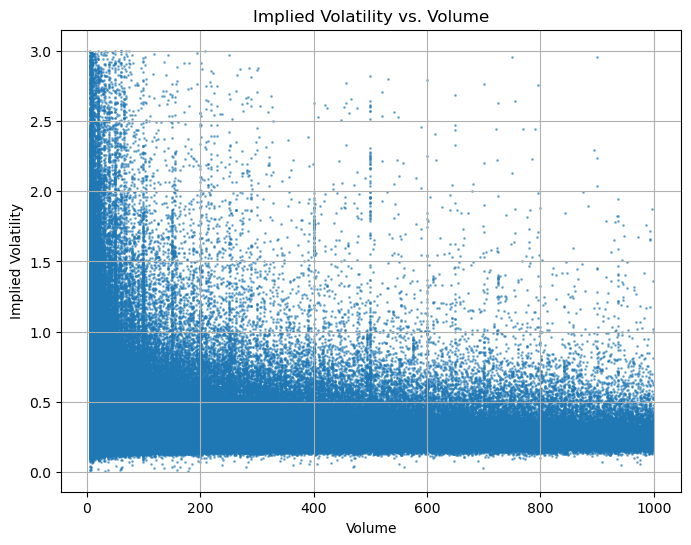

In [276]:
# Extract the relevant columns
x = combined_df['VOLUME']  # Days to Expiry
y = combined_df['IV']   # Implied Volatility

# Create the plot
plt.figure(figsize=(8, 6))   # Adjust the figure size as needed
plt.scatter(x, y, marker='o', s = 1, alpha = 0.5)   # Add markers to highlight data points
plt.xlabel('Volume')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Volume')
plt.grid(True)

# Display the plot
plt.show()

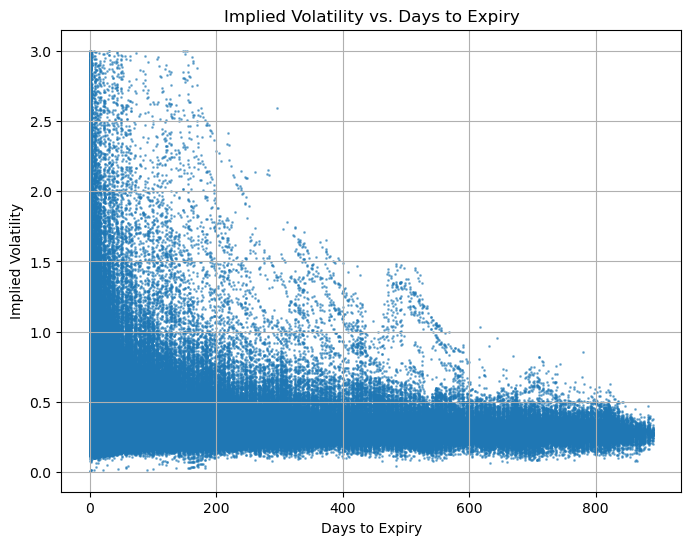

In [277]:
# Extract the relevant columns
x = combined_df['DTE']  # Days to Expiry
y = combined_df['IV']   # Implied Volatility

# Create the plot
plt.figure(figsize=(8, 6))   # Adjust the figure size as needed
plt.scatter(x, y, marker='o', s = 1, alpha = 0.5)   # Add markers to highlight data points
plt.xlabel('Days to Expiry')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Days to Expiry')
plt.grid(True)

# Display the plot
plt.show()

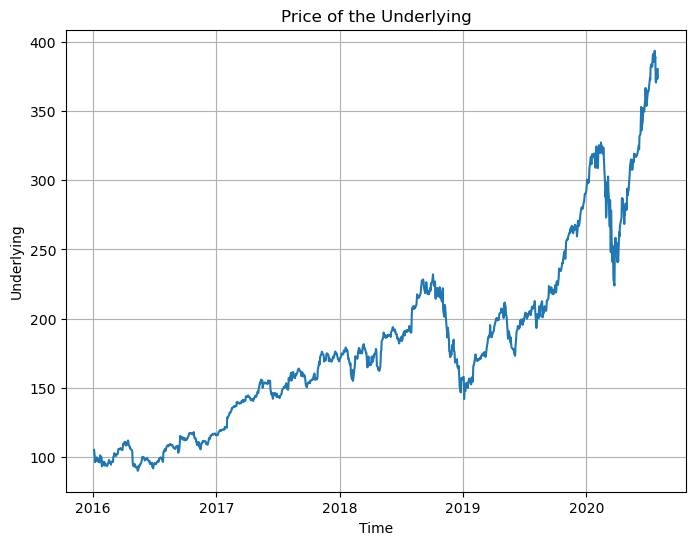

In [278]:
# Extract the relevant columns
x = combined_df['UNDERLYING_LAST']  # Days to Expiry

# Create the plot
plt.figure(figsize=(8, 6))   # Adjust the figure size as needed
plt.plot(x)   # Add markers to highlight data points
plt.ylabel('Underlying')
plt.xlabel('Time')
plt.title('Price of the Underlying')
plt.grid(True)

# Display the plot
plt.show()

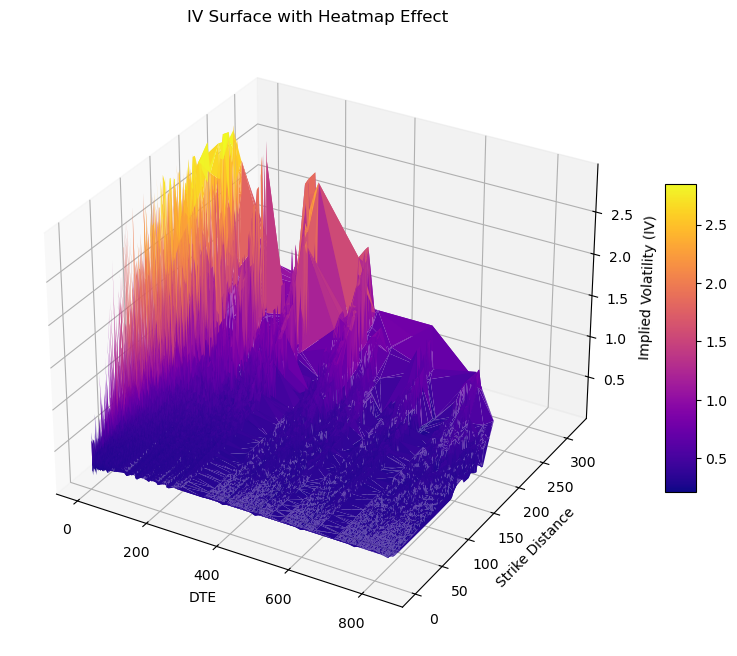

In [279]:
# Extract x, y, z from the filtered data
x = test_df['DTE']
y = test_df['STRIKE_DISTANCE']
z = test_df['IV']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot using plot_trisurf with a colormap to create a heatmap effect
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')

# Add a colorbar to show the mapping from color to IV
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel("DTE")
ax.set_ylabel("Strike Distance")
ax.set_zlabel("Implied Volatility (IV)")
ax.set_title("IV Surface with Heatmap Effect")

plt.show()

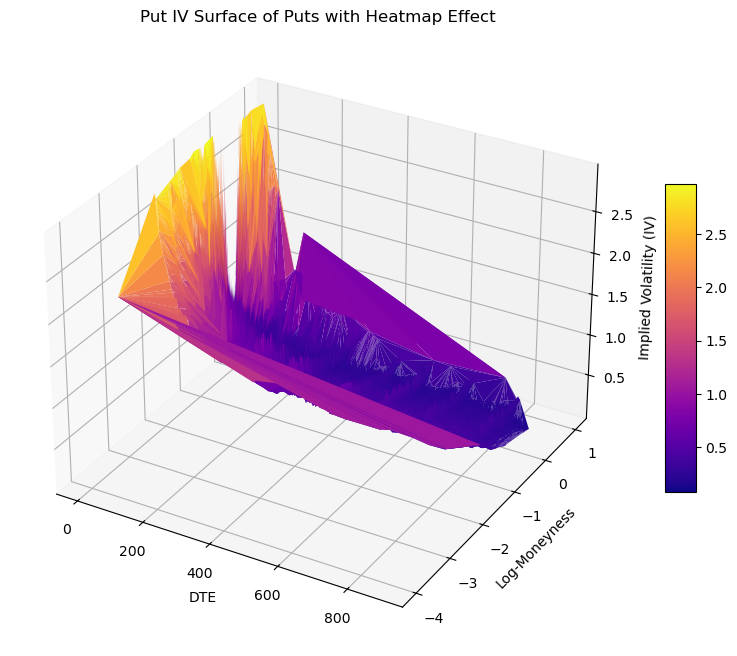

In [280]:
# Extract x, y, z from the filtered data
put_df = combined_df[combined_df['OPTION_TYPE'] == 'P']
y = put_df['LOG_MONEYNESS']
x = put_df['DTE']
z = put_df['IV']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot using plot_trisurf with a colormap to create a heatmap effect
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')

# Add a colorbar to show the mapping from color to IV
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("Implied Volatility (IV)")
ax.set_title("Put IV Surface of Puts with Heatmap Effect")

plt.show()

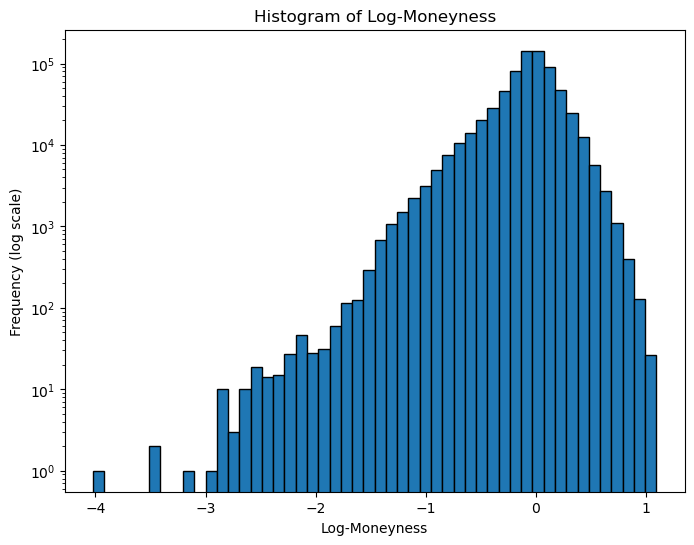

In [281]:
plt.figure(figsize=(8, 6))
plt.hist(combined_df['LOG_MONEYNESS'], bins=50, edgecolor='k')
plt.yscale('log')
plt.xlabel('Log-Moneyness')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Log-Moneyness')
plt.show()

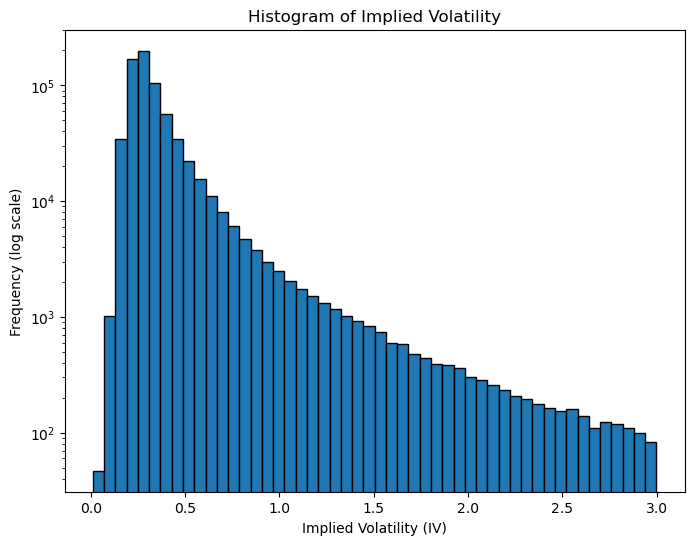

In [282]:
plt.figure(figsize=(8, 6))
plt.hist(combined_df['IV'], bins=50, edgecolor='k')
plt.yscale('log')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Implied Volatility')
plt.show()

# 3. Model Design

We will build each model in turn

## Data Processing

In [283]:
# Define the target and features
target = 'IV'
# For this example we use all columns except the target.
# 'OPTION_TYPE' is the only categorical column.
features = [col for col in combined_df.columns if col != target]


# Split the data into training and test sets
X_train = train_df[features]
y_train = train_df[target]

X_val = valid_df[features]
y_val = valid_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Identify numeric and categorical features
numeric_features = [col for col in features if col != 'OPTION_TYPE']
categorical_features = ['OPTION_TYPE']

# Preprocessing: scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Fit the preprocessor on training data and transform both training and test data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Determine the input dimension for the neural network
input_dim = X_train_proc.shape[1]

## Regression

In [284]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Initialize the linear regression model
model_reg = LinearRegression()

# Fit the linear regression model on the training data.
# Train the model using your prepared training and validation data
history = model_reg.fit(X_train_proc, y_train)


## MLP

In [285]:
from sklearn.neural_network import MLPRegressor
# Initialize the linear regression model
model_MLP = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',             # Nonlinear activation ReLU is defualut
    solver='adam',                 # Default Optimiser
    alpha=0.0001,                  # Learning rate
    max_iter=200,                  # Max training iterations
)

# Fit the linear regression model on the training data.
history = model_MLP.fit(X_train_proc, y_train)


## FNN

In [286]:
# Basic Feedforward neural networks

# Identify numeric and categorical features
numeric_features = [col for col in features if col != 'OPTION_TYPE']
categorical_features = ['OPTION_TYPE']


# Preprocessing: scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Fit the preprocessor on training data and transform both training and test data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Build a basic feed-forward neural network model
model_FNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output for IV
])

# Compile the model with mean squared error loss and Adam optimizer
model_FNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_FNN = callbacks.ModelCheckpoint(
    'FNN_Best.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)

# Define early stopping to stop training when validation loss doesn't improve
early_stopping_FNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)

'''# Train the model using your prepared training and validation data
history = model_FNN.fit(
    X_train_proc, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_proc, y_val),
    verbose=1,
    callbacks=[best_model_FNN, early_stopping_FNN]
)'''


'# Train the model using your prepared training and validation data\nhistory = model_FNN.fit(\n    X_train_proc, y_train,\n    epochs=50,\n    batch_size=64,\n    validation_data=(X_val_proc, y_val),\n    verbose=1,\n    callbacks=[best_model_FNN, early_stopping_FNN]\n)'

## RNN

In [287]:
date_counts = combined_df.groupby(combined_df.index).size()
print(date_counts.describe(percentiles=[.00001, .0001, .001, .01, .05, .1, .25, .5, .75]))

count     1148.000000
mean       603.510453
std        212.392382
min        198.000000
0.001%     199.491100
0.01%      212.911000
0.1%       328.147000
1%         351.000000
5%         388.350000
10%        408.000000
25%        448.000000
50%        526.500000
75%        715.000000
max       1367.000000
dtype: float64


 This shows that 99% of the data has over 351 columns, so we will use this as a bound for each day

In [288]:
'''train_preprocessed = preprocessor.fit_transform(train_df)
# Convert back to DataFrame to preserve index and get feature names
train_preprocessed_df = pd.DataFrame(
    train_preprocessed, 
    index=train_df.index, 
    columns=preprocessor.get_feature_names_out()
)
train_preprocessed_df['IV'] = train_df['IV']

# Transform the validation and test sets using the fitted preprocessor
valid_preprocessed = preprocessor.transform(valid_df)
valid_preprocessed_df = pd.DataFrame(
    valid_preprocessed, 
    index=valid_df.index, 
    columns=preprocessor.get_feature_names_out()
)
valid_preprocessed_df['IV'] = valid_df['IV']


test_preprocessed = preprocessor.transform(test_df)
test_preprocessed_df = pd.DataFrame(
    test_preprocessed, 
    index=test_df.index, 
    columns=preprocessor.get_feature_names_out()
)
test_preprocessed_df['IV'] = test_df['IV']
train_preprocessed_df

def create_daily_sequences(data, feature_cols, target_col):
    target_length = 351
    # Define the target and features

    # For this we use all columns except the target.
    feature_cols = [col for col in data.columns if col != target_col]
    daily_sequences = []
    daily_sequences_target = []
    for date, group in data.groupby(data.index):
        # Skip days that don't have enough rows
        if len(group) < target_length:
            continue

        # Randomly sample target_length rows, then sort by index if you need chronological order
        if len(group) > target_length:

            sampled = group.sample(n=target_length, random_state=42)
            sequence = sampled[feature_cols].values
            target = sampled[target_col].values
        # Extract the features for that day as a sequence (2D array: number of rows x number of features)
        else:
            sequence = group[feature_cols].values
            target = group[target_col].values
        daily_sequences.append(sequence)
        daily_sequences_target.append(target)

        # daily_sequences is now a list where each element is a 2D NumPy array containing all rows for a given date.
    return np.array(daily_sequences), np.array(daily_sequences_target)

X_train_RNN, y_train_RNN = create_daily_sequences(train_preprocessed_df, numeric_features, target)
X_val_RNN, y_val_RNN = create_daily_sequences(valid_preprocessed_df, numeric_features, target)
X_test_RNN, y_test_RNN = create_daily_sequences(test_preprocessed_df, numeric_features, target)

print(len(X_train_RNN), len(X_train_RNN[0]), len(X_train_RNN[0][1]))
print(len(y_train_RNN), len(y_train_RNN[0]))
print(X_train_RNN)'''


"train_preprocessed = preprocessor.fit_transform(train_df)\n# Convert back to DataFrame to preserve index and get feature names\ntrain_preprocessed_df = pd.DataFrame(\n    train_preprocessed, \n    index=train_df.index, \n    columns=preprocessor.get_feature_names_out()\n)\ntrain_preprocessed_df['IV'] = train_df['IV']\n\n# Transform the validation and test sets using the fitted preprocessor\nvalid_preprocessed = preprocessor.transform(valid_df)\nvalid_preprocessed_df = pd.DataFrame(\n    valid_preprocessed, \n    index=valid_df.index, \n    columns=preprocessor.get_feature_names_out()\n)\nvalid_preprocessed_df['IV'] = valid_df['IV']\n\n\ntest_preprocessed = preprocessor.transform(test_df)\ntest_preprocessed_df = pd.DataFrame(\n    test_preprocessed, \n    index=test_df.index, \n    columns=preprocessor.get_feature_names_out()\n)\ntest_preprocessed_df['IV'] = test_df['IV']\ntrain_preprocessed_df\n\ndef create_daily_sequences(data, feature_cols, target_col):\n    target_length = 351\n   

In [289]:
'''# Build a basic RNN model using LSTM for regression
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=True, activation='relu'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear')),
    tf.keras.layers.Reshape((351,))  # Regression output (for IV)
])

# Compile the model with mean squared error loss and the Adam optimizer
model_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_RNN = callbacks.ModelCheckpoint(
    'RNN_Best.keras', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
    )

early_stopping_RNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)


# Train the model using your prepared training and validation data
history = model_RNN.fit(
    X_train_RNN, y_train_RNN,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_RNN, y_val_RNN),
    verbose=1,
    callbacks=[best_model_RNN, early_stopping_RNN]
)


'''

"# Build a basic RNN model using LSTM for regression\nmodel_RNN = tf.keras.models.Sequential([\n    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),\n    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),\n    tf.keras.layers.LSTM(16, return_sequences=True, activation='relu'),\n    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear')),\n    tf.keras.layers.Reshape((351,))  # Regression output (for IV)\n])\n\n# Compile the model with mean squared error loss and the Adam optimizer\nmodel_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n                  loss='mean_squared_error')\n\n# Define a callback to save the best model based on the validation loss\nbest_model_RNN = callbacks.ModelCheckpoint(\n    'RNN_Best.keras', \n    monitor='val_loss', \n    verbose=1,\n    save_best_only=True, \n    save_weights_only=False, \n    mode='min'\n    )\n\nearly_stopping_RNN = callbacks.EarlyStopping(\n    monitor='val

In [290]:
'''# Evaluate the model on the test set
test_loss_RNN = model_RNN.evaluate(X_test_RNN, y_test_RNN)
print(f"Test loss: {test_loss_RNN}")

# Make a Prediction on the test set
y_pred_RNN = model_RNN.predict(X_test_RNN)


print(y_pred_RNN)
print(len(y_test_RNN), len(y_test_RNN[0]))
# print(len(y_pred_RNN), len(y_pred_RNN[0]), len(y_pred_RNN[0][1]))


# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test_RNN, y_pred_RNN)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_RNN, y_pred_RNN)
test_mae = mean_absolute_error(y_test_RNN, y_pred_RNN)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred_RNN = model_RNN.predict(X_test_RNN).flatten()

print(y_pred_RNN)

_, RNN_LOG_MONEYNESS = create_daily_sequences(test_df, numeric_features, 'LOG_MONEYNESS')
_, RNN_DTE = create_daily_sequences(test_df, numeric_features, 'DTE')



# Extract x, y, z from the filtered data
y = RNN_LOG_MONEYNESS.flatten()
x = RNN_DTE.flatten()
z = y_pred_RNN

print("Lengths:", len(x), len(y), len(z))  # They should all match

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot using plot_trisurf with a colormap to create a heatmap effect
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')

# Add a colorbar to show the mapping from color to IV
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("Implied Volatility (IV)")
ax.set_title("IV Surface Generated Under RNN")

plt.show()'''

'# Evaluate the model on the test set\ntest_loss_RNN = model_RNN.evaluate(X_test_RNN, y_test_RNN)\nprint(f"Test loss: {test_loss_RNN}")\n\n# Make a Prediction on the test set\ny_pred_RNN = model_RNN.predict(X_test_RNN)\n\n\nprint(y_pred_RNN)\nprint(len(y_test_RNN), len(y_test_RNN[0]))\n# print(len(y_pred_RNN), len(y_pred_RNN[0]), len(y_pred_RNN[0][1]))\n\n\n# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)\ntest_mse = mean_squared_error(y_test_RNN, y_pred_RNN)\ntest_rmse = np.sqrt(test_mse)\ntest_r2 = r2_score(y_test_RNN, y_pred_RNN)\ntest_mae = mean_absolute_error(y_test_RNN, y_pred_RNN)\n\nprint(f"Test MSE: {test_mse}")\nprint(f"Test RMSE: {test_rmse}")\nprint(f"Test R² Score: {test_r2}")\nprint(f"Test MAE: {test_mae}")\n\n# Make predictions on the test set\ny_pred_RNN = model_RNN.predict(X_test_RNN).flatten()\n\nprint(y_pred_RNN)\n\n_, RNN_LOG_MONEYNESS = create_daily_sequences(test_df, numeric_features, \'LOG_MONEYNESS\')\n_, RNN_DTE = cre

In [291]:
time_window = 5

def create_sequences(data, sequence_length):
    """
    Creates sequences where each sequence consists of 'sequence_length' consecutive data.
    The label is the target value of the data immediately following the sequence.
    """
    X = []
    for i in range(len(data) - sequence_length):
        seq_x = data[i:i+sequence_length]
        X.append(seq_x)
    return np.array(X)

X_train_RNN = create_sequences(X_train_proc, time_window)
X_val_RNN = create_sequences(X_val_proc, time_window)
X_test_RNN = create_sequences(X_test_proc, time_window)

y_train_RNN = create_sequences(y_train, time_window)
y_val_RNN = create_sequences(y_val, time_window)
y_test_RNN = create_sequences(y_test, time_window)




print(len(X_train_RNN), len(X_train_RNN[0]), len(X_train_RNN[0][1]))

561279 5 10


In [292]:
# Build a basic RNN model using LSTM for regression
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation='linear'),
])

# Compile the model with mean squared error loss and the Adam optimizer
model_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                  loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_RNN = callbacks.ModelCheckpoint(
    'RNN_Best.keras', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)

early_stopping_RNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)


'''# Train the model using your prepared training and validation data
history = model_RNN.fit(
    X_train_RNN, y_train[5:],
    epochs=50,
    batch_size=64,
    validation_data=(X_val_RNN, y_val[5:]),
    verbose=1,
    callbacks=[best_model_RNN, early_stopping_RNN]
)'''

'# Train the model using your prepared training and validation data\nhistory = model_RNN.fit(\n    X_train_RNN, y_train[5:],\n    epochs=50,\n    batch_size=64,\n    validation_data=(X_val_RNN, y_val[5:]),\n    verbose=1,\n    callbacks=[best_model_RNN, early_stopping_RNN]\n)'

## RNN and FNN

### RRN for Volatility

In [293]:

#Compile the data for predicing Volatility, only take short term volitility predictions
Vol_RNN_df = combined_df.loc[combined_df['DTE'] <= 5, ['UNDERLYING_LAST', 'IV']].copy()



Vol_RNN_df = Vol_RNN_df.groupby(level=0).agg({'UNDERLYING_LAST': 'mean', 'IV': ['mean', 'max', 'min']})

# Rename columns for clarity
Vol_RNN_df.columns = ['UNDERLYING_LAST', 'IV_mean', 'IV_max', 'IV_min']


window = 5


# Compute log-returns of the underlying
Vol_RNN_df['log_return'] = np.log(Vol_RNN_df['UNDERLYING_LAST'] / Vol_RNN_df['UNDERLYING_LAST'].shift(1))

#Compute rolling standard deviation of log-returns and annualize
Vol_RNN_df['realized_vol'] = Vol_RNN_df['log_return'].rolling(window).std() * np.sqrt(252)
Vol_RNN_df.head(10)

UNDERLYING_LAST   IV_mean   IV_max   IV_min  log_return  \
Date                                                                           
2016-01-04 21:00:00           105.35  0.422509  0.80527  0.24377         NaN   
2016-01-05 21:00:00           102.71  0.548619  1.04433  0.29725   -0.025379   
2016-01-06 21:00:00           100.70  0.529998  1.08609  0.29162   -0.019764   
2016-01-07 21:00:00            96.48  0.687611  1.09807  0.37929   -0.042810   
2016-01-08 21:00:00            96.96  0.797362  1.27226  0.32022    0.004963   
2016-01-11 21:00:00            98.53  0.632511  2.36361  0.26601    0.016063   
2016-01-12 21:00:00            99.96  0.807099  2.65662  0.20831    0.014409   
2016-01-13 21:00:00            97.41  0.844131  2.45356  0.33850   -0.025841   
2016-01-14 21:00:00            99.51  0.981415  2.77986  0.25322    0.021329   
2016-01-15 21:00:00            97.13  1.181650  2.90570  0.29810   -0.024208   

                     realized_vol  
Date                               
2016-01-04 21:00:00           NaN  
2016-01-05 21:00:00           NaN  
2016-01-06 21:00:00           NaN  
2016-01-07 21:00:00           NaN  
2016-01-08 21:00:00           NaN  
2016-01-11 21:00:00      0.376846  
2016-01-12 21:00:00      0.402087  
2016-01-13 21:00:00      0.417748  
2016-01-14 21:00:00      0.299280  
2016-01-15 21:00:00      0.370062

In [294]:
TRAIN_CUTOFF_VOL = pd.to_datetime(TRAIN_CUTOFF) - 2 * (pd.to_datetime(END_DATE) - pd.to_datetime(VALID_CUTOFF))

# Define the target and features
target_Vol = 'realized_vol'
# For this example we use all columns except the target.
# 'OPTION_TYPE' is the only categorical column.
features_Vol = [col for col in Vol_RNN_df.columns if col != target]


# Train, validation, test splits:
Vol_RNN_train_df = Vol_RNN_df[
    (Vol_RNN_df.index > '2016-01-11') &  # Start from the 11th to aviod the NaN
    (Vol_RNN_df.index < TRAIN_CUTOFF_VOL)
]
Vol_RNN_valid_df = Vol_RNN_df[
    (Vol_RNN_df.index >= TRAIN_CUTOFF_VOL) & 
    (Vol_RNN_df.index < VALID_CUTOFF)
]

Vol_RNN_test_df  = Vol_RNN_df[
    (Vol_RNN_df.index >= VALID_CUTOFF) & 
    (Vol_RNN_df.index < END_DATE)
]

print(Vol_RNN_test_df.shape)



X_train_Vol, y_train_Vol = Vol_RNN_train_df[features_Vol], Vol_RNN_train_df[target_Vol]
X_valid_Vol, y_valid_Vol = Vol_RNN_valid_df[features_Vol], Vol_RNN_valid_df[target_Vol]
X_test_Vol, y_test_Vol = Vol_RNN_test_df[features_Vol], Vol_RNN_test_df[target_Vol]


X_train_Vol_RNN = create_sequences(X_train_Vol, 5)
y_train_Vol_RNN = create_sequences(y_train_Vol, 5)
X_valid_Vol_RNN = create_sequences(X_valid_Vol, 5)
y_valid_Vol_RNN = create_sequences(y_valid_Vol, 5)
X_test_Vol_RNN = create_sequences(X_test_Vol, 5)
y_test_Vol_RNN = create_sequences(y_test_Vol, 5)

print(X_test_Vol_RNN, len(X_test_Vol_RNN), len(X_test_Vol_RNN[0]), len(X_test_Vol_RNN[0][0]))

(62, 6)
[[[ 2.93950000e+02  1.36686362e+00  2.72669000e+00  4.35110000e-01
    2.13871444e-02  3.25226212e-01]
  [ 2.89070000e+02  1.39161632e+00  2.93827000e+00  5.45530000e-01
   -1.67408115e-02  3.49908108e-01]
  [ 2.93160000e+02  6.73207213e-01  2.05704000e+00  3.01940000e-01
    1.40496617e-02  3.53622642e-01]
  [ 2.97560000e+02  8.83173800e-01  2.46573000e+00  3.15860000e-01
    1.48973503e-02  2.89742694e-01]
  [ 3.00630000e+02  1.02059083e+00  2.94389000e+00  2.13060000e-01
    1.02643874e-02  2.35141904e-01]]

 [[ 2.89070000e+02  1.39161632e+00  2.93827000e+00  5.45530000e-01
   -1.67408115e-02  3.49908108e-01]
  [ 2.93160000e+02  6.73207213e-01  2.05704000e+00  3.01940000e-01
    1.40496617e-02  3.53622642e-01]
  [ 2.97560000e+02  8.83173800e-01  2.46573000e+00  3.15860000e-01
    1.48973503e-02  2.89742694e-01]
  [ 3.00630000e+02  1.02059083e+00  2.94389000e+00  2.13060000e-01
    1.02643874e-02  2.35141904e-01]
  [ 3.03740000e+02  1.25660657e+00  2.97561000e+00  2.79320000e

In [295]:
# Build a basic RNN model using LSTM for regression
model_Vol_RNN = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output (for IV)
])

# Compile the model with mean squared error loss and the Adam optimizer
model_Vol_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                  loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_Vol_RNN = callbacks.ModelCheckpoint(
    'Vol_RNN_Best.keras', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)


early_stopping_Vol_RNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)



# Train the model using your prepared training and validation data
history = model_Vol_RNN.fit(
    X_train_Vol_RNN, y_train_Vol[5:],
    epochs=50,
    batch_size=32,
    validation_data=(X_valid_Vol_RNN, y_valid_Vol[5:]),
    verbose=1,
    callbacks=[best_model_Vol_RNN, early_stopping_Vol_RNN]
)


Epoch 1/50
20/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0864
Epoch 1: val_loss improved from inf to 0.10911, saving model to Vol_RNN_Best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0730 - val_loss: 0.1091
Epoch 2/50
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198
Epoch 2: val_loss did not improve from 0.10911
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - val_loss: 0.1199
Epoch 3/50
19/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0166
Epoch 3: val_loss did not improve from 0.10911
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - val_loss: 0.1142
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0156
Epoch 4: val_loss did not improve from 0.10911
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - val_loss: 0.1181
Epoch 5/50
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179
Epoch 5: val_loss did not improve from 0.10911
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - val_loss: 0.1092
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━

In [296]:
# Build the new DF
y_pred_Vol_RNN = model_Vol_RNN.predict(X_test_Vol_RNN)

print(y_pred_Vol_RNN, len(y_pred_Vol_RNN))


Vol_combined_df = combined_df.copy()

Vol_combined_df['realized_vol'] = Vol_RNN_df['realized_vol']


# Filter out data on/after END_DATE_datetime
Vol_combined_df = Vol_combined_df[Vol_combined_df.index > '2016-01-11']# Start from the 11th to aviod the NaN


# Train, validation, test splits:
Vol_train_df = Vol_combined_df[
    (Vol_combined_df.index >= TRAIN_START) &  
    (Vol_combined_df.index < TRAIN_CUTOFF)
]

Vol_valid_df = Vol_combined_df[
    (Vol_combined_df.index >= TRAIN_CUTOFF) & 
    (Vol_combined_df.index < VALID_CUTOFF)
]

Vol_test_df  = Vol_combined_df[
    (Vol_combined_df.index >= VALID_CUTOFF) &
    (Vol_combined_df.index < END_DATE)
]


print(Vol_test_df.index.unique(), len(Vol_test_df.index.unique()))


y_pred_Vol_RNN_df = pd.DataFrame(
    y_pred_Vol_RNN, 
    index=Vol_test_df.index.unique()[5:], 
    columns=['realized_vol']
)

# This overmaps the volatility we generated with the RNN

Vol_test_df.loc[y_pred_Vol_RNN_df.index, 'realized_vol'] = y_pred_Vol_RNN_df['realized_vol']




# Define the target and features
target = 'IV'
# For this example we use all columns except the target.
# 'OPTION_TYPE' is the only categorical column.
features = [col for col in combined_df.columns if col != target]


# Split the data into training and test sets
X_train_Vol_FNN = Vol_train_df[features]
y_train_Vol_FNN = Vol_train_df[target]

X_val_Vol_FNN = Vol_valid_df[features]
y_val_Vol_FNN = Vol_valid_df[target]

X_test_Vol_FNN = Vol_test_df[features]
y_test_Vol_FNN = Vol_test_df[target]

Vol_test_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[[0.22713152]
 [0.22371706]
 [0.14999479]
 [0.14043486]
 [0.21222538]
 [0.2596389 ]
 [0.25671464]
 [0.23652276]
 [0.21874398]
 [0.21143124]
 [0.20756403]
 [0.2291205 ]
 [0.23400691]
 [0.20773157]
 [0.18661842]
 [0.1574325 ]
 [0.16411269]
 [0.16143769]
 [0.13878399]
 [0.1334725 ]
 [0.14896664]
 [0.18195021]
 [0.19870034]
 [0.20801821]
 [0.21975327]
 [0.3696619 ]
 [0.37444746]
 [0.3436526 ]
 [0.33216467]
 [0.3299202 ]
 [0.23309502]
 [0.21140918]
 [0.21063513]
 [0.23205903]
 [0.22086501]
 [0.29194048]
 [0.27482507]
 [0.24268639]
 [0.25016704]
 [0.25264838]
 [0.18737486]
 [0.17379561]
 [0.19165945]
 [0.18024942]
 [0.17266268]
 [0.17951033]
 [0.17546082]
 [0.14974391]
 [0.16933417]
 [0.17327827]
 [0.17829767]
 [0.19342193]
 [0.18103677]
 [0.28395686]
 [0.2983765 ]
 [0.29695892]
 [0.28855485]] 57
DatetimeIndex(['2020-04-30 20:00:00', '2020-05-01 20:00:00',
               '2020-05-04 20:00:00', '2020-05-05 20:00:00',
               '2020-05-06 20:00:00',

UNDERLYING_LAST     DTE  STRIKE  STRIKE_DISTANCE  \
Date                                                                    
2020-04-30 20:00:00           293.95  169.00   440.0            146.1   
2020-04-30 20:00:00           293.95  232.04   145.0            148.9   
2020-04-30 20:00:00           293.95  232.04   180.0            113.9   
2020-04-30 20:00:00           293.95  232.04   200.0             93.9   
2020-04-30 20:00:00           293.95  232.04   240.0             53.9   
...                              ...     ...     ...              ...   
2020-07-29 20:00:00           380.27   30.00   480.0             99.7   
2020-07-29 20:00:00           380.27   30.00   495.0            114.7   
2020-07-29 20:00:00           380.27   30.00   550.0            169.7   
2020-07-29 20:00:00           380.27   30.00   500.0            119.7   
2020-07-29 20:00:00           380.27   30.00   367.5             12.8   

                     STRIKE_DISTANCE_PCT       IV  VOLUME OPTION_TYPE  \
Date                                                                    
2020-04-30 20:00:00                0.497  0.30316   128.0           C   
2020-04-30 20:00:00                0.507  0.69020     5.0           C   
2020-04-30 20:00:00                0.388  0.50027     8.0           C   
2020-04-30 20:00:00                0.320  0.43681     5.0           C   
2020-04-30 20:00:00                0.184  0.37592    54.0           C   
...                                  ...      ...     ...         ...   
2020-07-29 20:00:00                0.262  0.38450     6.0           C   
2020-07-29 20:00:00                0.302  0.42071    12.0           C   
2020-07-29 20:00:00                0.446  0.49121    13.0           C   
2020-07-29 20:00:00                0.315  0.43084    35.0           C   
2020-07-29 20:00:00                0.034  0.32581    29.0           C   

                     LOG_MONEYNESS  MID_PRICE  realized_vol  
Date                                                         
2020-04-30 20:00:00       0.403365      0.680      0.325226  
2020-04-30 20:00:00      -0.706676    149.705      0.325226  
2020-04-30 20:00:00      -0.490453    116.395      0.325226  
2020-04-30 20:00:00      -0.385092     97.900      0.325226  
2020-04-30 20:00:00      -0.202771     64.475      0.325226  
...                            ...        ...           ...  
2020-07-29 20:00:00       0.232905      0.325      0.288555  
2020-07-29 20:00:00       0.263676      0.290      0.288555  
2020-07-29 20:00:00       0.369037      0.105      0.288555  
2020-07-29 20:00:00       0.273727      0.275      0.288555  
2020-07-29 20:00:00      -0.034158     21.170      0.288555  

[66313 rows x 11 columns]

In [297]:
# Basic Feedforward neural networks

# Identify numeric and categorical features
numeric_features = [col for col in features if col != 'OPTION_TYPE']
categorical_features = ['OPTION_TYPE']

# Preprocessing: scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Fit the preprocessor on training data and transform both training and test data
X_train_Vol_FNN_proc = preprocessor.fit_transform(X_train_Vol_FNN)
X_val_Vol_FNN_proc = preprocessor.transform(X_val_Vol_FNN)
X_test_Vol_FNN_proc = preprocessor.transform(X_test_Vol_FNN)


# Build a basic feed-forward neural network model
model_Vol_FNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output for IV
])

# Compile the model with mean squared error loss and Adam optimizer
model_Vol_FNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_Vol_FNN = callbacks.ModelCheckpoint(
    'Vol_FNN_Best.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)


early_stopping_Vol_FNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)


'''# Train the model using your prepared training and validation data
history = model_Vol_FNN.fit(
    X_train_Vol_FNN_proc, y_train_Vol_FNN,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_Vol_FNN_proc, y_val_Vol_FNN),
    verbose=1,
    callbacks=[best_model_Vol_FNN, early_stopping_Vol_FNN]
)'''


'# Train the model using your prepared training and validation data\nhistory = model_Vol_FNN.fit(\n    X_train_Vol_FNN_proc, y_train_Vol_FNN,\n    epochs=50,\n    batch_size=64,\n    validation_data=(X_val_Vol_FNN_proc, y_val_Vol_FNN),\n    verbose=1,\n    callbacks=[best_model_Vol_FNN, early_stopping_Vol_FNN]\n)'

# 4. Training & Validation

## Regression

In [298]:
# Make a Prediction on the test set
y_pred_reg = model_reg.predict(X_test_proc)

# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test, y_pred_reg)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_reg)
test_mae = mean_absolute_error(y_test, y_pred_reg)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

Test MSE: 0.06059702288125979
Test RMSE: 0.24616462556845933
Test R² Score: 0.3021659656482434
Test MAE: 0.13284124587392654


## MLP

In [299]:
# Make a Prediction on the test set
y_pred_MLP = model_MLP.predict(X_test_proc)

# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test, y_pred_MLP)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_MLP)
test_mae = mean_absolute_error(y_test, y_pred_MLP)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

Test MSE: 0.007399343822222343
Test RMSE: 0.08601943863001167
Test R² Score: 0.9147893129810173
Test MAE: 0.05061395714489163


## FNN

In [300]:
# Train the model using your prepared training and validation data
history_FNN = model_FNN.fit(
    X_train_proc, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_proc, y_val),
    verbose=1,
    callbacks=[best_model_FNN, early_stopping_FNN]
)

# Evaluate the model on the test set
test_loss_FNN = model_FNN.evaluate(X_test_proc, y_test)
print(f"Test loss: {test_loss_FNN}")



Epoch 1/50
4349/4386 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 1: val_loss improved from inf to 0.02513, saving model to FNN_Best.keras
4386/4386 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0124 - val_loss: 0.0251
Epoch 2/50
4368/4386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059
Epoch 2: val_loss improved from 0.02513 to 0.02330, saving model to FNN_Best.keras
4386/4386 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0059 - val_loss: 0.0233
Epoch 3/50
4351/4386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047
Epoch 3: val_loss improved from 0.02330 to 0.01719, saving model to FNN_Best.keras
4386/4386 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0047 - val_loss: 0.0172
Epoch 4/50
4386/4386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 4: val_loss improved from 0.01719 to 0.01706, saving model to FNN_Best.keras
4386/4386 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 5/50
4354/4386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041
Epoch 5: val_loss d

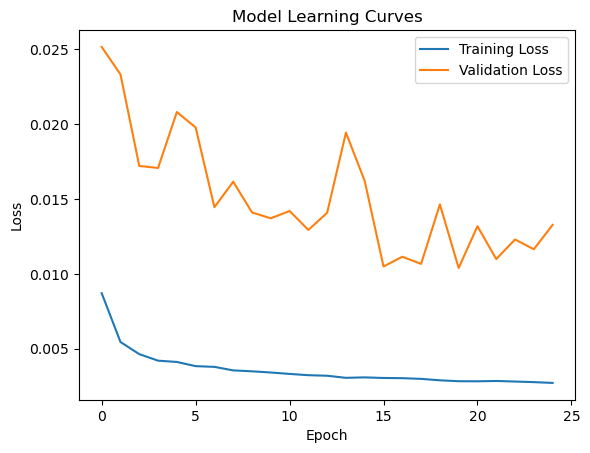

In [301]:
# Extract loss arrays
train_loss = history_FNN.history['loss']
val_loss   = history_FNN.history.get('val_loss') 

# Plot learning curves
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Learning Curves')
plt.legend()
plt.show()

In [302]:
# Make a Prediction on the test set
y_pred_FNN = model_FNN.predict(X_test_proc)

# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test, y_pred_FNN)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_FNN)
test_mae = mean_absolute_error(y_test, y_pred_FNN)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
Test MSE: 0.00823583504193617
Test RMSE: 0.09075150159604066
Test R² Score: 0.905156297779981
Test MAE: 0.04950523881424695


## RNN

In [303]:
# Train the model using your prepared training and validation data
history_RNN = model_RNN.fit(
    X_train_RNN, y_train[5:],
    epochs=50,
    batch_size=128,
    validation_data=(X_val_RNN, y_val[5:]),
    verbose=1,
    callbacks=[best_model_RNN, early_stopping_RNN]
)

# Evaluate the model on the test set
test_loss_RNN = model_RNN.evaluate(X_test_RNN, y_test[5:])
print(f"Test loss: {test_loss_RNN}")

Epoch 1/50
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0368
Epoch 1: val_loss improved from inf to 0.06446, saving model to RNN_Best.keras
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.0368 - val_loss: 0.0645
Epoch 2/50
4381/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313
Epoch 2: val_loss improved from 0.06446 to 0.06131, saving model to RNN_Best.keras
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0313 - val_loss: 0.0613
Epoch 3/50
4383/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303
Epoch 3: val_loss did not improve from 0.06131
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0303 - val_loss: 0.0675
Epoch 4/50
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303
Epoch 4: val_loss did not improve from 0.06131
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0303 - val_loss: 0.0625
Epoch 5/50
4375/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0300
Epoch 5: val_loss did not improve from 0.06131
4385/4385 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/s

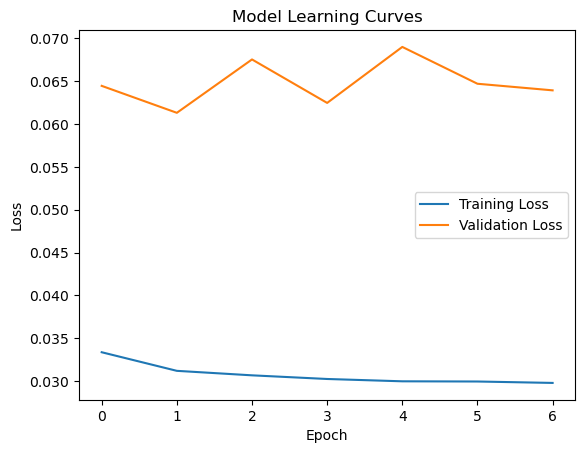

In [304]:
# Extract loss arrays
train_loss = history_RNN.history['loss']
val_loss   = history_RNN.history.get('val_loss') 

# Plot learning curves
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Learning Curves')
plt.legend()
plt.show()

In [305]:
# Make a Prediction on the test set
y_pred_RNN = model_RNN.predict(X_test_RNN)

# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test[5:], y_pred_RNN)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test[5:], y_pred_RNN)
test_mae = mean_absolute_error(y_test[5:], y_pred_RNN)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test MSE: 0.04858145286932315
Test RMSE: 0.2204120070897299
Test R² Score: 0.4405707458393816
Test MAE: 0.1095573551162764


## RNN and FNN

### RRN for Volatility

In [306]:
# Train the model using your prepared training and validation data
history_Vol_RNN = model_Vol_RNN.fit(
    X_train_Vol_RNN, y_train_Vol[5:],
    epochs=50,
    validation_data=(X_valid_Vol_RNN, y_valid_Vol[5:]),
    verbose=1,
    callbacks=[best_model_Vol_RNN, early_stopping_Vol_RNN]
)


Epoch 1/50
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 1: val_loss improved from 0.02325 to 0.02211, saving model to Vol_RNN_Best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0221
Epoch 2/50
25/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 2: val_loss did not improve from 0.02211
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0248
Epoch 3/50
22/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 3: val_loss did not improve from 0.02211
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0256
Epoch 4/50
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051
Epoch 4: val_loss did not improve from 0.02211
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0264
Epoch 5/50
25/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 5: val_loss improved from 0.02211 to 0.01874, saving model to Vol_RNN_Best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.

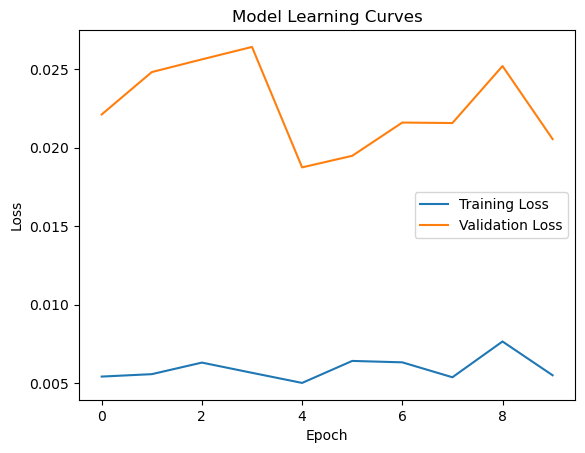

In [307]:
# Extract loss arrays
train_loss = history_Vol_RNN.history['loss']
val_loss   = history_Vol_RNN.history.get('val_loss')  

# Plot learning curves
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Learning Curves')
plt.legend()
plt.show()

In [308]:
# Evaluate the model on the test set
test_loss_Vol_RNN = model_Vol_RNN.evaluate(X_test_Vol_RNN, y_test_Vol[5:])
print(f"Test loss: {test_loss_Vol_RNN}")


# Make a Prediction on the test set
y_pred_Vol_RNN = model_Vol_RNN.predict(X_test_Vol_RNN)


# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test_Vol[5:], y_pred_Vol_RNN)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_Vol[5:], y_pred_Vol_RNN)
test_mae = mean_absolute_error(y_test_Vol[5:], y_pred_Vol_RNN)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")


y_pred_Vol_RNN_df = pd.DataFrame(
    y_pred_Vol_RNN, 
    index=Vol_test_df.index.unique()[5:], 
    columns=['realized_vol']
)

# This overmaps the volatility we generated with the RNN

Vol_test_df.loc[y_pred_Vol_RNN_df.index, 'realized_vol'] = y_pred_Vol_RNN_df['realized_vol']



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073
Test loss: 0.006632637232542038
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test MSE: 0.006632637187286914
Test RMSE: 0.08144100433618752
Test R² Score: 0.5336779250278836
Test MAE: 0.06211347833084373


In [309]:
# Train the model using your prepared training and validation data
history_Vol_FNN = model_Vol_FNN.fit(
    X_train_Vol_FNN_proc, y_train_Vol_FNN,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_Vol_FNN_proc, y_val_Vol_FNN),
    verbose=1,
    callbacks=[best_model_Vol_FNN, early_stopping_Vol_FNN]
)

# Evaluate the model on the test set
test_loss_Vol_FNN = model_Vol_FNN.evaluate(X_test_Vol_FNN_proc, y_test_Vol_FNN)
print(f"Test loss: {test_loss_Vol_FNN}")



Epoch 1/50
4316/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0334
Epoch 1: val_loss improved from inf to 0.03907, saving model to Vol_FNN_Best.keras
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 5s 982us/step - loss: 0.0332 - val_loss: 0.0391
Epoch 2/50
4360/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0091
Epoch 2: val_loss did not improve from 0.03907
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 4s 943us/step - loss: 0.0091 - val_loss: 0.0402
Epoch 3/50
4323/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.0066
Epoch 3: val_loss improved from 0.03907 to 0.03074, saving model to Vol_FNN_Best.keras
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 4s 894us/step - loss: 0.0066 - val_loss: 0.0307
Epoch 4/50
4354/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0055
Epoch 4: val_loss did not improve from 0.03074
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 4s 926us/step - loss: 0.0055 - val_loss: 0.0336
Epoch 5/50
4349/4363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0049
Epoch 5: val_loss did not improve from 0.03074
4363/4363 ━━━━━━━━

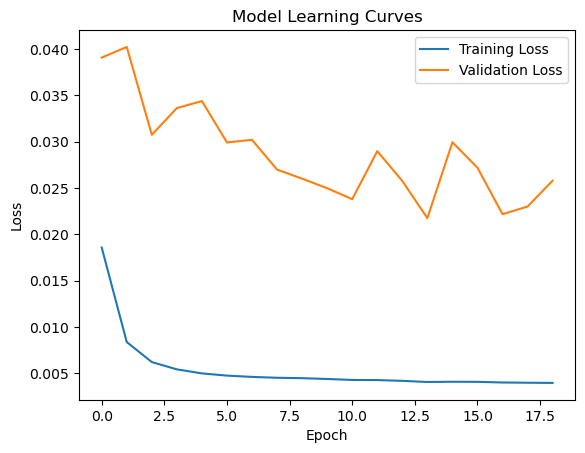

In [310]:
# Extract loss arrays
train_loss = history_Vol_FNN.history['loss']
val_loss   = history_Vol_FNN.history.get('val_loss') 

# Plot learning curves
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Learning Curves')
plt.legend()
plt.show()

In [311]:
# Make a Prediction on the test set
y_pred_Vol_FNN = model_Vol_FNN.predict(X_test_Vol_FNN_proc)

# Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
test_mse = mean_squared_error(y_test_Vol_FNN, y_pred_Vol_FNN)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_Vol_FNN, y_pred_Vol_FNN)
test_mae = mean_absolute_error(y_test_Vol_FNN, y_pred_Vol_FNN)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")
print(f"Test MAE: {test_mae}")

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step
Test MSE: 0.011977314952851632
Test RMSE: 0.10944091991961523
Test R² Score: 0.8620694942286526
Test MAE: 0.07392413389599135


# 5. Results & Analysis

## Combined IV Plot

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step


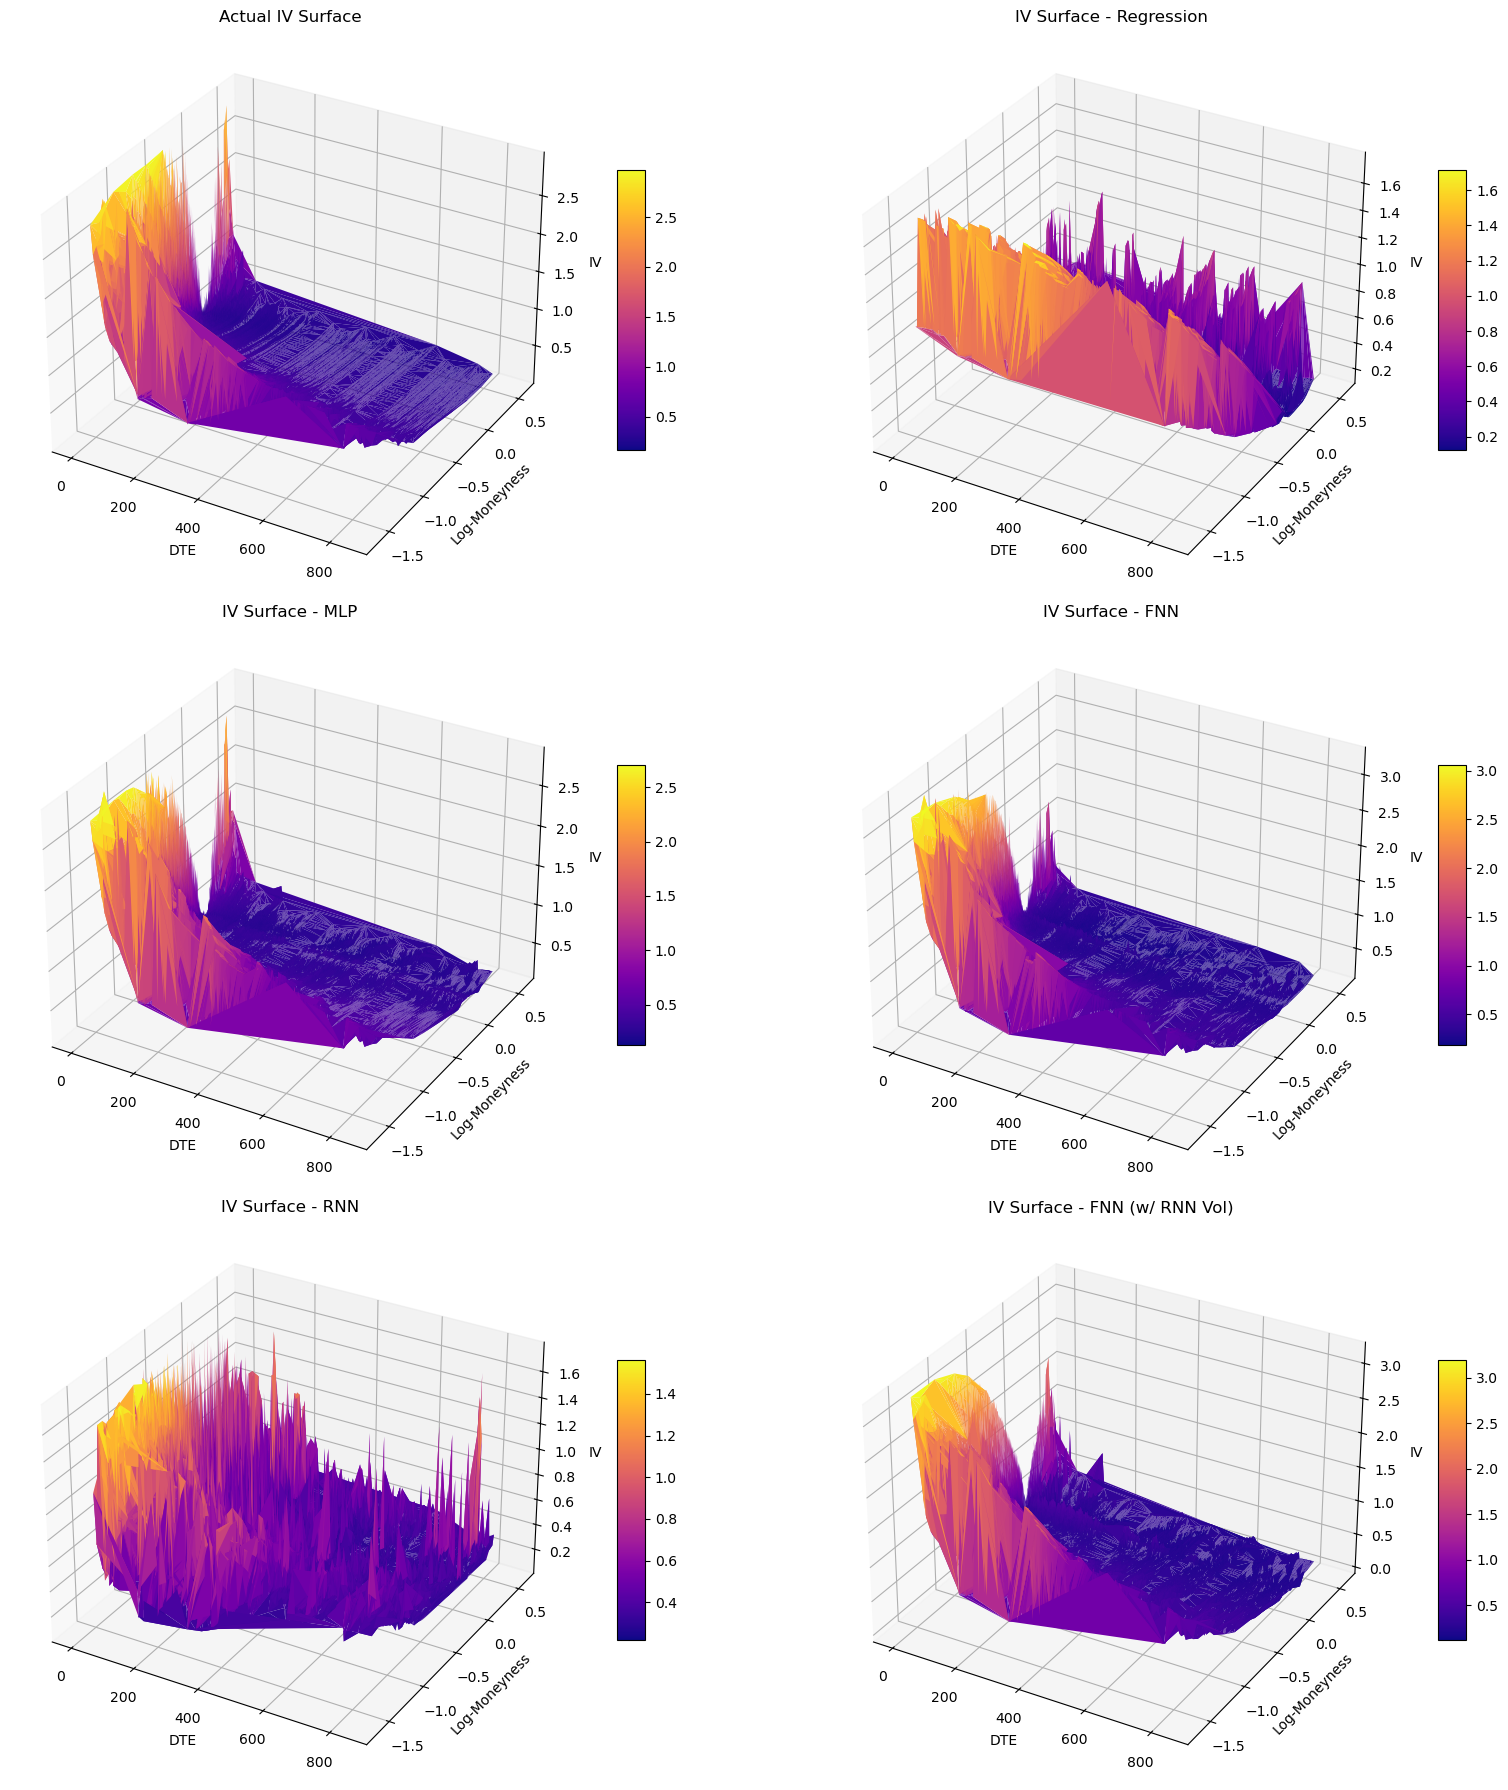

In [318]:
fig = plt.figure(figsize=(18, 18))

# Plot 1: Actual IV Surface
ax = fig.add_subplot(3, 2, 1, projection='3d')
x, y, z = test_df['DTE'], test_df['LOG_MONEYNESS'], test_df['IV']
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Actual IV Surface")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

# Plot 2: Regression
ax = fig.add_subplot(3, 2, 2, projection='3d')
z = model_reg.predict(X_test_proc)
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("IV Surface - Regression")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

# Plot 3: MLP
ax = fig.add_subplot(3, 2, 3, projection='3d')
z = model_MLP.predict(X_test_proc)
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("IV Surface - MLP")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

# Plot 4: FNN
ax = fig.add_subplot(3, 2, 4, projection='3d')
z = model_FNN.predict(X_test_proc).flatten()
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("IV Surface - FNN")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

# Plot 5: RNN
ax = fig.add_subplot(3, 2, 5, projection='3d')
x_rnn = test_df['DTE'][5:]
y_rnn = test_df['LOG_MONEYNESS'][5:]
z = model_RNN.predict(X_test_RNN).flatten()
surf = ax.plot_trisurf(x_rnn, y_rnn, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("IV Surface - RNN")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

# Plot 6: Vol-FNN
ax = fig.add_subplot(3, 2, 6, projection='3d')
z = model_Vol_FNN.predict(X_test_Vol_FNN_proc).flatten()
surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("IV Surface - FNN (w/ RNN Vol)")
ax.set_xlabel("DTE")
ax.set_ylabel("Log-Moneyness")
ax.set_zlabel("IV")

plt.tight_layout()
plt.show()

This second plot is nomalised ot the same range to make it more readable

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step


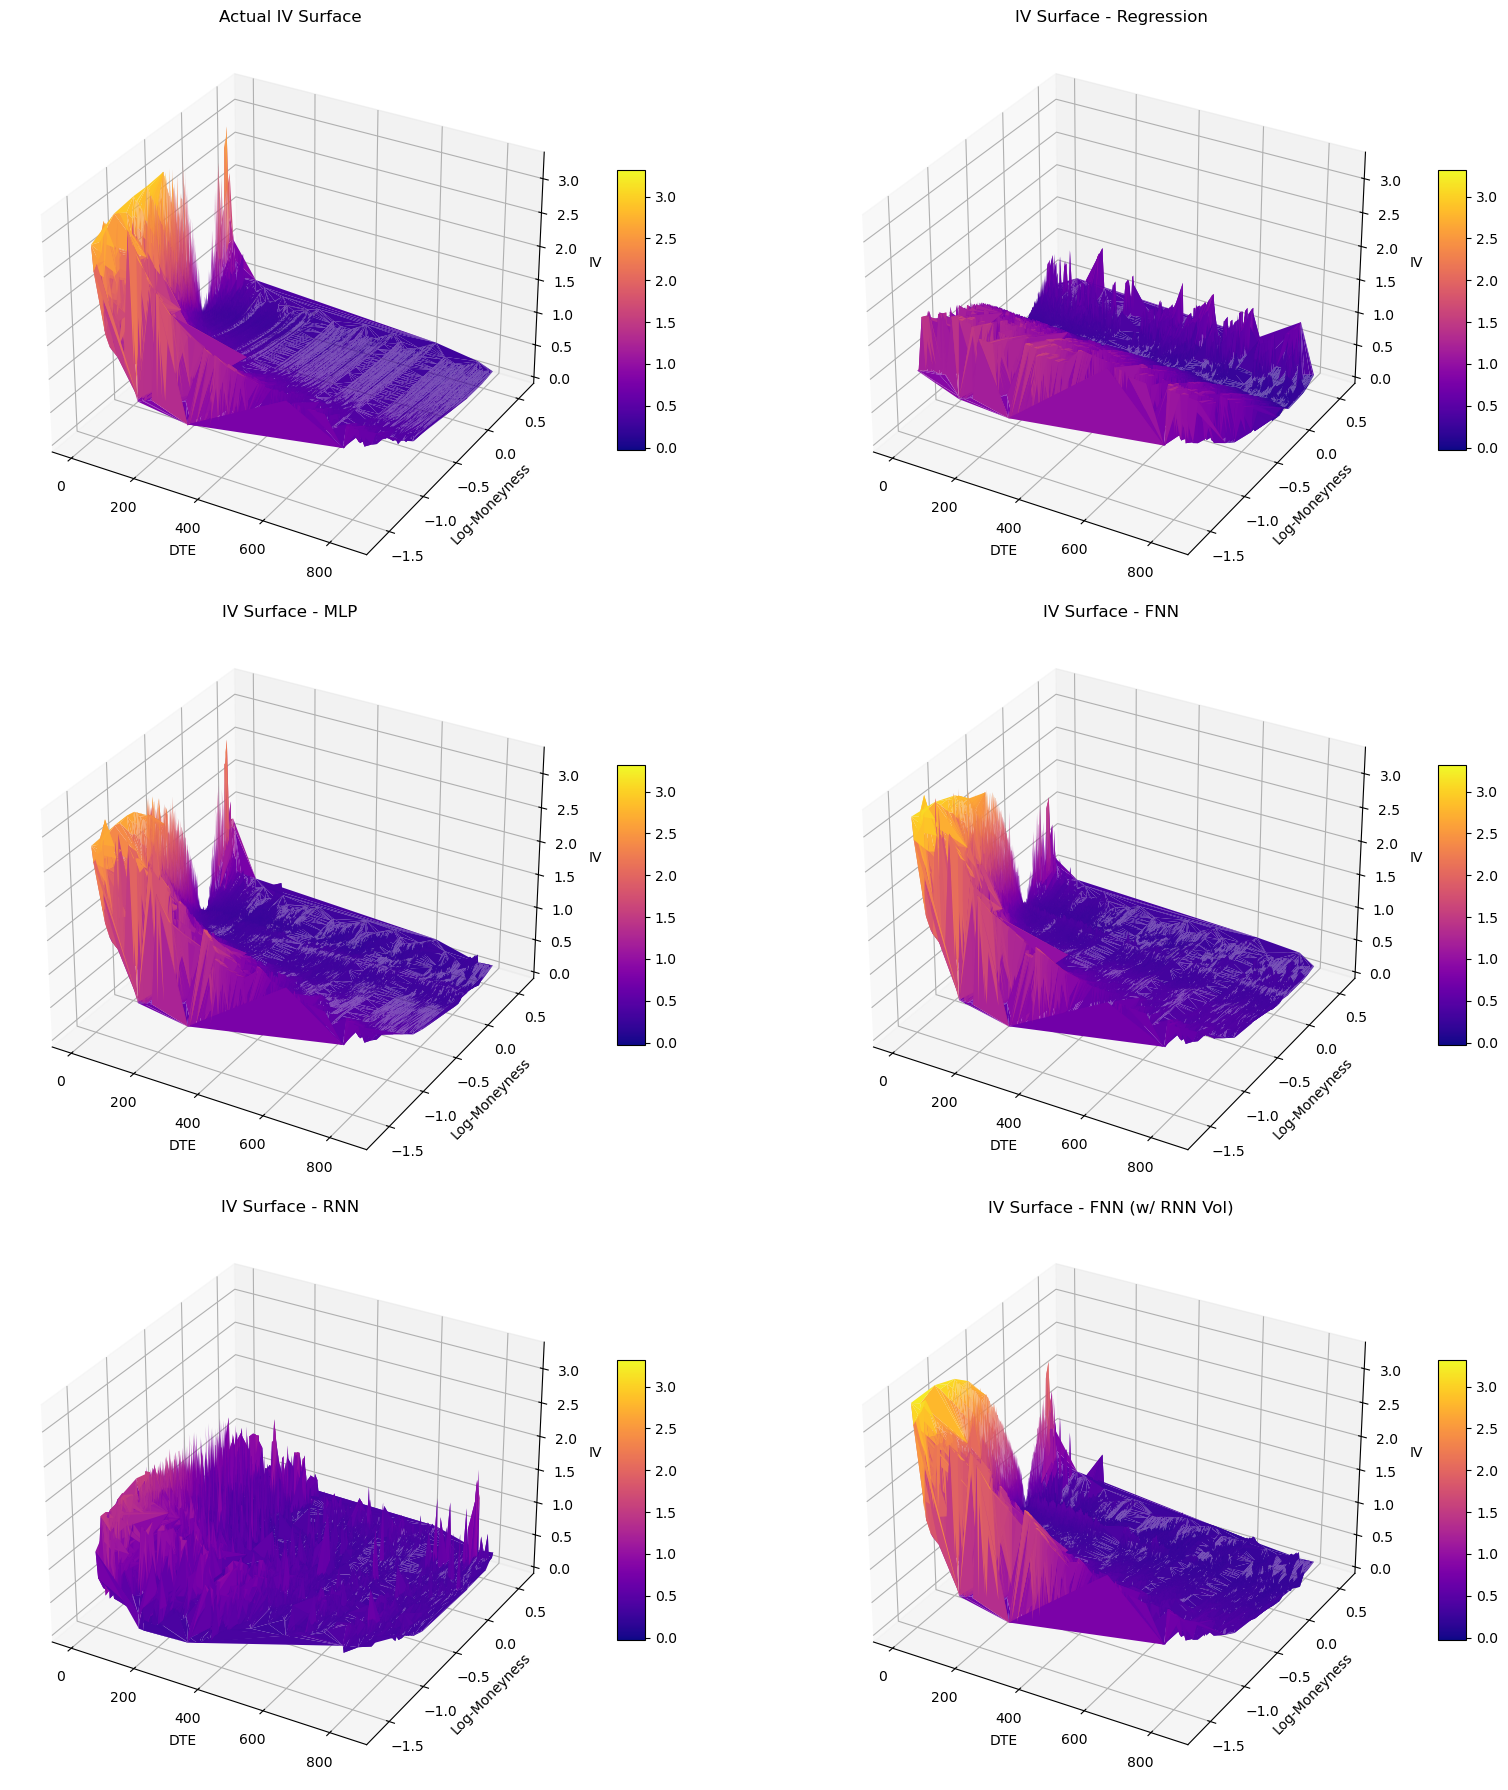

In [319]:
# Collect all z values to determine global vmin and vmax
z_actual = test_df['IV']
z_reg = model_reg.predict(X_test_proc)
z_mlp = model_MLP.predict(X_test_proc)
z_fnn = model_FNN.predict(X_test_proc).flatten()
z_rnn = model_RNN.predict(X_test_RNN).flatten()
z_vol_fnn = model_Vol_FNN.predict(X_test_Vol_FNN_proc).flatten()

# Combine all into a single array to get global min/max
all_z = np.concatenate([z_actual, z_reg, z_mlp, z_fnn, z_rnn, z_vol_fnn])
vmin, vmax = np.min(all_z), np.max(all_z)

fig = plt.figure(figsize=(18, 18))

# Helper function to add surface plots with shared color scale
def plot_surface(ax, x, y, z, title):
    surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none', vmin=vmin, vmax=vmax)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title(title)
    ax.set_xlabel("DTE")
    ax.set_ylabel("Log-Moneyness")
    ax.set_zlabel("IV")
    ax.set_zlim(vmin, vmax)

# Plot 1: Actual IV Surface
ax = fig.add_subplot(3, 2, 1, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_actual, "Actual IV Surface")

# Plot 2: Regression
ax = fig.add_subplot(3, 2, 2, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_reg, "IV Surface - Regression")

# Plot 3: MLP
ax = fig.add_subplot(3, 2, 3, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_mlp, "IV Surface - MLP")

# Plot 4: FNN
ax = fig.add_subplot(3, 2, 4, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_fnn, "IV Surface - FNN")

# Plot 5: RNN
ax = fig.add_subplot(3, 2, 5, projection='3d')
x_rnn = test_df['DTE'][5:]
y_rnn = test_df['LOG_MONEYNESS'][5:]
plot_surface(ax, x_rnn, y_rnn, z_rnn, "IV Surface - RNN")

# Plot 6: Vol-FNN
ax = fig.add_subplot(3, 2, 6, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_vol_fnn, "IV Surface - FNN (w/ RNN Vol)")

plt.tight_layout()
plt.show()


## Model Absolute Distances

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step
2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step


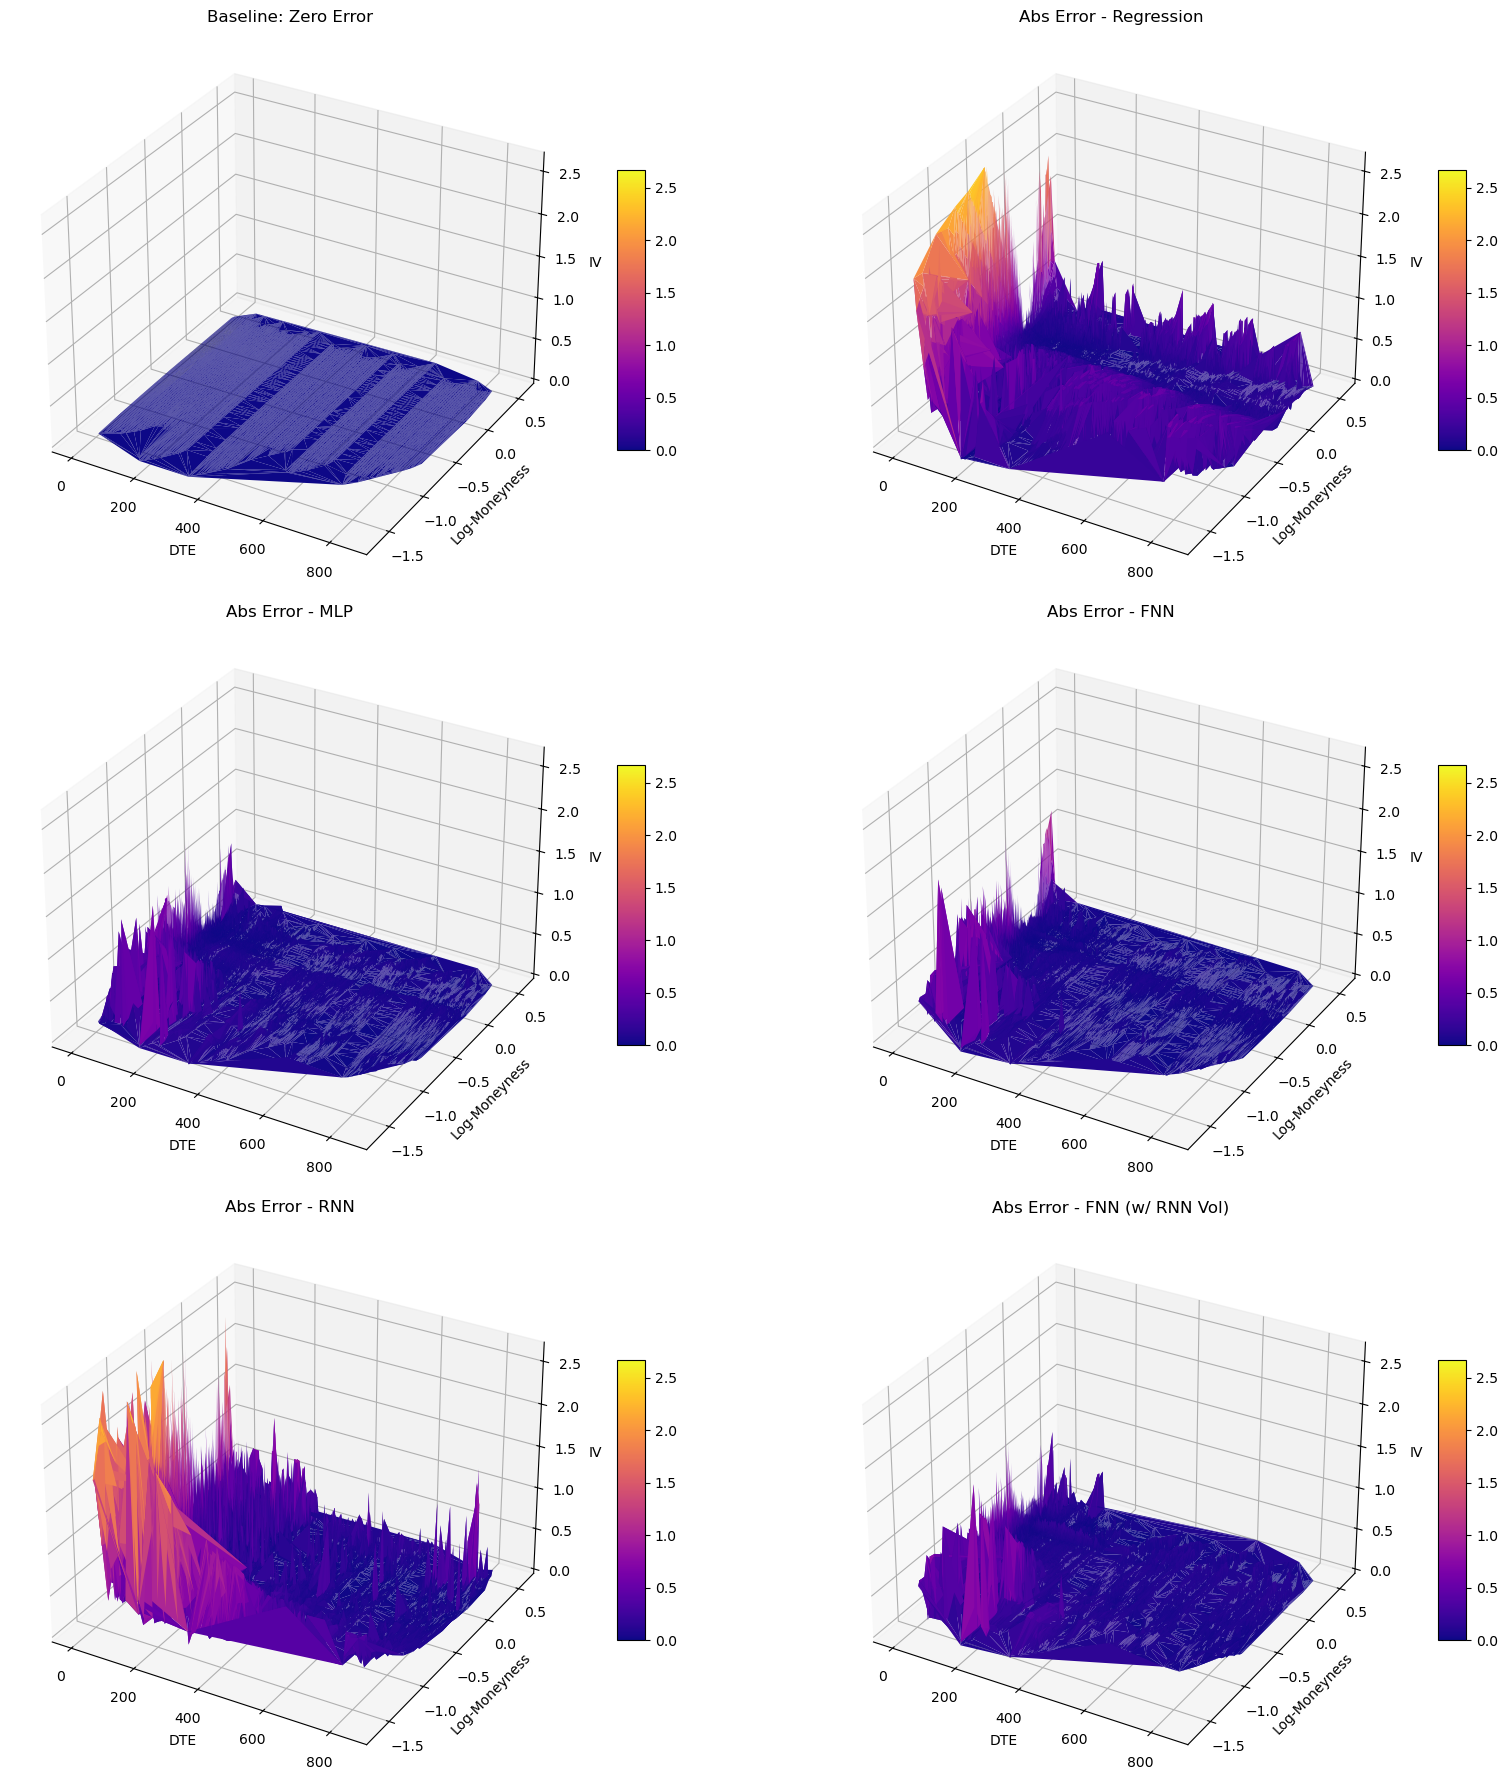

In [320]:
# Collect all z values to determine global vmin and vmax
z_actual = test_df['IV']
z_reg = np.abs(model_reg.predict(X_test_proc) - z_actual)
z_mlp = np.abs(model_MLP.predict(X_test_proc) - z_actual)
z_fnn = np.abs(model_FNN.predict(X_test_proc).flatten() - z_actual)
z_rnn = np.abs(model_RNN.predict(X_test_RNN).flatten() - z_actual[5:])
z_vol_fnn = np.abs(model_Vol_FNN.predict(X_test_Vol_FNN_proc).flatten() - z_actual)
z_actual = np.zeros_like(test_df['IV'])

# Combine all into a single array to get global min/max
all_z = np.concatenate([z_actual, z_reg, z_mlp, z_fnn, z_rnn, z_vol_fnn])
vmin, vmax = np.min(all_z), np.max(all_z)

fig = plt.figure(figsize=(18, 18))

# Helper function to add surface plots with shared color scale
def plot_surface(ax, x, y, z, title):
    surf = ax.plot_trisurf(x, y, z, cmap='plasma', edgecolor='none', vmin=vmin, vmax=vmax)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title(title)
    ax.set_xlabel("DTE")
    ax.set_ylabel("Log-Moneyness")
    ax.set_zlabel("IV")
    ax.set_zlim(vmin, vmax)


# Plot 1: Actual IV Surface
ax = fig.add_subplot(3, 2, 1, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_actual, "Baseline: Zero Error")

# Plot 2: Regression
ax = fig.add_subplot(3, 2, 2, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_reg, "Abs Error - Regression")

# Plot 3: MLP
ax = fig.add_subplot(3, 2, 3, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_mlp, "Abs Error - MLP")

# Plot 4: FNN
ax = fig.add_subplot(3, 2, 4, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_fnn, "Abs Error - FNN")

# Plot 5: RNN
ax = fig.add_subplot(3, 2, 5, projection='3d')
x_rnn = test_df['DTE'][5:]
y_rnn = test_df['LOG_MONEYNESS'][5:]
plot_surface(ax, x_rnn, y_rnn, z_rnn, "Abs Error - RNN")

# Plot 6: Vol-FNN
ax = fig.add_subplot(3, 2, 6, projection='3d')
plot_surface(ax, test_df['DTE'], test_df['LOG_MONEYNESS'], z_vol_fnn, "Abs Error - FNN (w/ RNN Vol)")

plt.tight_layout()
plt.show()

 ## Time series split K-fold Cross-Validation

In [321]:
# Sequence creation
def create_sequences(data, sequence_length):
    return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])


In [322]:
def preprocess_data(train_df, valid_df, test_df, target='IV', categorical_cols=['OPTION_TYPE']):
    # Define features
    features = [col for col in train_df.columns if col != target]
    
    # Split into X and y
    X_train = train_df[features]
    y_train = train_df[target]

    X_val = valid_df[features]
    y_val = valid_df[target]

    X_test = test_df[features]
    y_test = test_df[target]

    # Identify numeric and categorical features
    numeric_features = [col for col in features if col not in categorical_cols]
    categorical_features = categorical_cols

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    # Fit and transform
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)

    return X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, preprocessor

X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, preprocessor = preprocess_data(train_df, valid_df, test_df)

print(X_train_proc, len(X_train_proc), len(X_train_proc[0]))

[[-0.99732581 -0.28896473 -0.22727273 ...  2.19002123  0.
   1.        ]
 [-0.99732581 -0.28896473 -0.11363636 ...  2.89844303  0.
   1.        ]
 [-0.99732581 -0.25578309 -0.96590909 ... -0.26079264  0.
   1.        ]
 ...
 [ 2.25612836  0.76317785  0.11363636 ... -0.22009908  0.
   1.        ]
 [ 2.25612836  0.76317785 -0.625      ... -0.25690021  0.
   1.        ]
 [ 2.25612836  0.76317785 -0.56818182 ... -0.25583864  0.
   1.        ]] 561284 10


In [323]:
'''
def preprocess_and_sequence_data(train_df, valid_df, test_df, target='IV', categorical_cols=['OPTION_TYPE'], target_length=351):
    # Get feature columns
    features = [col for col in train_df.columns if col != target]
    numeric_features = [col for col in features if col not in categorical_cols]

    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    # Fit and transform train, transform valid/test
    def transform_df(df, fit=False):
        transformed = (
            preprocessor.fit_transform(df) if fit else preprocessor.transform(df)
        )
        processed_df = pd.DataFrame(
            transformed,
            index=df.index,
            columns=preprocessor.get_feature_names_out()
        )
        processed_df[target] = df[target]
        return processed_df

    train_processed = transform_df(train_df, fit=True)
    valid_processed = transform_df(valid_df)
    test_processed = transform_df(test_df)

    # Sequence builder
    def create_sequences(df):
        feature_cols = [col for col in df.columns if col != target]
        sequences, targets = [], []

        for date, group in df.groupby(df.index):
            if len(group) < target_length:
                continue
            elif len(group) > target_length:
                group = group.sample(n=target_length, random_state=42)
            seq = group[feature_cols].values
            tgt = group[target].values
            sequences.append(seq)
            targets.append(tgt)

        return np.array(sequences), np.array(targets)

    # Generate RNN inputs
    X_train, y_train = create_sequences(train_processed)
    X_val, y_val = create_sequences(valid_processed)
    X_test, y_test = create_sequences(test_processed)

    return X_train, y_train, X_val, y_val, X_test, y_test, preprocessor

X_train_RNN, y_train_RNN, X_val_RNN, y_val_RNN, X_test_RNN, y_test_RNN, preprocessor = preprocess_and_sequence_data(
    train_df, valid_df, test_df
)

print(X_train_RNN, len(X_train_RNN), len(X_train_RNN[0]), len(X_train_RNN[0][1]))'''

"\ndef preprocess_and_sequence_data(train_df, valid_df, test_df, target='IV', categorical_cols=['OPTION_TYPE'], target_length=351):\n    # Get feature columns\n    features = [col for col in train_df.columns if col != target]\n    numeric_features = [col for col in features if col not in categorical_cols]\n\n    # Define preprocessor\n    preprocessor = ColumnTransformer(\n        transformers=[\n            ('num', RobustScaler(), numeric_features),\n            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)\n        ]\n    )\n\n    # Fit and transform train, transform valid/test\n    def transform_df(df, fit=False):\n        transformed = (\n            preprocessor.fit_transform(df) if fit else preprocessor.transform(df)\n        )\n        processed_df = pd.DataFrame(\n            transformed,\n            index=df.index,\n            columns=preprocessor.get_feature_names_out()\n        )\n        processed_df[target] = df[target]\n        return processed_df\n\

In [324]:
def preprocess_and_create_sequences(train_df, valid_df, test_df, target='IV', 
                                    categorical_cols=['OPTION_TYPE'], time_window=5):
    # Define features
    features = [col for col in train_df.columns if col != target]
    numeric_features = [col for col in features if col not in categorical_cols]

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    # Split into X and y
    def split_xy(df):
        X = df[features]
        y = df[target]
        return X, y

    X_train_raw, y_train_raw = split_xy(train_df)
    X_val_raw, y_val_raw = split_xy(valid_df)
    X_test_raw, y_test_raw = split_xy(test_df)

    # Fit on training and transform all
    X_train_proc = preprocessor.fit_transform(X_train_raw)
    X_val_proc = preprocessor.transform(X_val_raw)
    X_test_proc = preprocessor.transform(X_test_raw)

    y_train = y_train_raw.to_numpy()
    y_val = y_val_raw.to_numpy()
    y_test = y_test_raw.to_numpy()

    def create_sequences(data, sequence_length):
        return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

    X_train_RNN = create_sequences(X_train_proc, time_window)
    X_val_RNN = create_sequences(X_val_proc, time_window)
    X_test_RNN = create_sequences(X_test_proc, time_window)

    y_train_RNN = y_train[time_window:]
    y_val_RNN = y_val[time_window:]
    y_test_RNN = y_test[time_window:]

    return X_train_RNN, y_train_RNN, X_val_RNN, y_val_RNN, X_test_RNN, y_test_RNN, preprocessor

X_train_RNN, y_train_RNN, X_val_RNN, y_val_RNN, X_test_RNN, y_test_RNN, preprocessor = preprocess_and_create_sequences(train_df, valid_df, test_df, time_window=5)

#print(type(X_train_RNN), X_train_RNN.shape)
#print(type(y_train_RNN), y_train_RNN.shape)

In [325]:
# Group by index (dates), and check if any row satisfies DTE <= 5 for each date
mask = combined_df['DTE'] <= 5

# Get all unique dates
all_dates = combined_df.index.unique()

# Filter to find dates with no DTE <= 5
dates_with_no_dte_le_5 = [date for date in all_dates if not any(mask.loc[combined_df.index == date])]

print(dates_with_no_dte_le_5)


[Timestamp('2016-06-03 20:00:00'), Timestamp('2016-06-10 20:00:00'), Timestamp('2017-01-20 21:00:00'), Timestamp('2018-09-21 20:00:00'), Timestamp('2018-12-21 21:00:00'), Timestamp('2019-04-18 20:00:00'), Timestamp('2019-05-03 20:00:00'), Timestamp('2019-05-17 20:00:00'), Timestamp('2019-05-24 20:00:00'), Timestamp('2019-06-07 20:00:00')]


Hello, congratulaions on making it this far into the notebook, sorry its so long: below we change the bound on the VOL_RNN_DF as there are missing elements for any value less than 7, I don't know why it worked earlier and does not work now, please let me know if you can work it out

In [326]:
#Compile the data for predicing Volatility, only take short term volitility predictions
Vol_RNN_df = combined_df.loc[combined_df['DTE'] <= 8, ['UNDERLYING_LAST', 'IV']].copy()



Vol_RNN_df = Vol_RNN_df.groupby(level=0).agg({'UNDERLYING_LAST': 'mean', 'IV': ['mean', 'max', 'min']})

# Rename columns for clarity
Vol_RNN_df.columns = ['UNDERLYING_LAST', 'IV_mean', 'IV_max', 'IV_min']


window = 5


# Compute log-returns of the underlying
Vol_RNN_df['log_return'] = np.log(Vol_RNN_df['UNDERLYING_LAST'] / Vol_RNN_df['UNDERLYING_LAST'].shift(1))

#Compute rolling standard deviation of log-returns and annualize
Vol_RNN_df['realized_vol'] = Vol_RNN_df['log_return'].rolling(window).std() * np.sqrt(252)



def prepare_volatility_rnn_data(vol_rnn_df, train_cutoff, valid_cutoff, end_date, window=5):
    """
    Prepares RNN sequence data using a precomputed Vol_RNN_df with realized_vol.
    """


    # Drop initial NaNs and start from 2016-01-11
    vol_df = vol_rnn_df[vol_rnn_df.index >= '2016-01-30'].copy()

    # Define features and target
    target_col = 'realized_vol'
    feature_cols = [col for col in vol_df.columns if col != target_col]

    # Split data
    train_df = vol_df[(vol_df.index < train_cutoff)]
    val_df = vol_df[(vol_df.index >= train_cutoff) & (vol_df.index < valid_cutoff)]
    test_df = vol_df[(vol_df.index >= valid_cutoff) & (vol_df.index < end_date)]

    # X/y split
    X_train, y_train = train_df[feature_cols].to_numpy(), train_df[target_col].to_numpy()
    X_val, y_val = val_df[feature_cols].to_numpy(), val_df[target_col].to_numpy()
    X_test, y_test = test_df[feature_cols].to_numpy(), test_df[target_col].to_numpy()

    def create_sequences(data, sequence_length):
        return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

    return (
        create_sequences(X_train, window), y_train[5:],
        create_sequences(X_val, window), y_val[5:],
        create_sequences(X_test, window), y_test[5:]
    )

X_train_Vol_RNN, y_train_Vol_RNN, X_val_Vol_RNN, y_val_Vol_RNN, X_test_Vol_RNN, y_test_Vol_RNN = prepare_volatility_rnn_data(Vol_RNN_df, TRAIN_CUTOFF, VALID_CUTOFF, '2017-01-30', window=5)

#print(X_train_Vol_RNN, len(X_train_Vol_RNN), len(X_train_Vol_RNN[0]), len(X_train_Vol_RNN[0]))
#print(type(X_train_Vol_RNN), X_train_Vol_RNN.shape)
#print(type(y_train_Vol_RNN), y_train_Vol_RNN.shape)


In [327]:
def prepare_volatility_fnn_data(train_df, valid_df, test_df, vol_rnn_df, y_pred_Vol_RNN, 
                                                 target='IV', categorical_cols=['OPTION_TYPE'],):
    """
    Joins realized_vol from vol_rnn_df into each split, and preprocesses for FNN training.
    """

    # Join realized_vol to each set using the index
    train_df = train_df.copy()
    valid_df = valid_df.copy()
    test_df = test_df.copy()

    train_df['realized_vol'] = vol_rnn_df['realized_vol']
    valid_df['realized_vol'] = vol_rnn_df['realized_vol']
    test_df['realized_vol'] = vol_rnn_df['realized_vol']

    y_pred_Vol_RNN_df = pd.DataFrame(
    y_pred_Vol_RNN, 
    index=test_df.index.unique()[5:], 
    columns=['realized_vol']
    )

    # This overmaps the volatility we generated with the RNN

    test_df.loc[y_pred_Vol_RNN_df.index, 'realized_vol'] = y_pred_Vol_RNN_df['realized_vol']


    # Define features (everything except target)
    features = [col for col in train_df.columns if col != target]
    numeric_features = [col for col in features if col not in categorical_cols]
    categorical_features = categorical_cols

    # Extract X and y
    X_train, y_train = train_df[features], train_df[target]
    X_val, y_val = valid_df[features], valid_df[target]
    X_test, y_test = test_df[features], test_df[target]

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)

    return (
        X_train_proc, y_train.to_numpy(),
        X_val_proc, y_val.to_numpy(),
        X_test_proc, y_test.to_numpy(),
        preprocessor
    )

X_train_Vol_FNN, y_train_Vol_FNN, X_val_Vol_FNN, y_val_Vol_FNN, X_test_Vol_FNN, y_test_Vol_FNN, preprocessor = prepare_volatility_fnn_data(
    train_df,
    valid_df,
    test_df,
    Vol_RNN_df,
    y_pred_Vol_RNN
)

#print(X_train_Vol_FNN, len(X_train_Vol_FNN), len(X_train_Vol_FNN[0]))

# Time series cross validations

In [328]:
train_periods = ["2016-07-30", "2017-01-30", "2017-07-30", "2018-01-30", "2018-07-30", "2019-01-30", "2019-07-30", "2020-01-30"]

valid_periods = ["2016-10-30", "2017-04-30", "2017-10-30", "2018-04-30", "2018-10-30", "2019-04-30", "2019-10-30", "2020-04-30"]

test_periods = ["2017-01-30", "2017-07-30", "2018-01-30", "2018-07-30", "2019-01-30", "2019-07-30", "2020-01-30", "2020-07-30"]



# Initialize the linear regression model
model_reg = LinearRegression()

# Fit the linear regression model on the training data.
# Train the model using your prepared training and validation data
history = model_reg.fit(X_train_proc, y_train)





test_mse = []
test_rmse = []
test_r2 = []
test_mae = []

for TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF in zip(train_periods, valid_periods, test_periods):
    # Train, validation, test splits:
    train_df = combined_df[
        (combined_df.index >= '2016-01-30') & 
        (combined_df.index < TRAIN_CUTOFF)
    ]

    valid_df = combined_df[
        (combined_df.index >= TRAIN_CUTOFF) & 
        (combined_df.index < VALID_CUTOFF)
    ]

    test_df  = combined_df[
        (combined_df.index >= VALID_CUTOFF) &
        (combined_df.index < TEST_CUTOFF)
    ]
    X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, preprocessor = preprocess_data(train_df, valid_df, test_df)
    
    history = model_reg.fit(X_train_proc, y_train)

    # Make a Prediction on the test set
    y_pred_reg = model_reg.predict(X_test_proc)

    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse.append(mean_squared_error(y_test, y_pred_reg))
    test_rmse.append(np.sqrt(test_mse[-1]))
    test_r2.append(r2_score(y_test, y_pred_reg))
    test_mae.append(mean_absolute_error(y_test, y_pred_reg))

print(f"Test MSE: {test_mse}, Mean MSE : {np.mean(test_mse)}")
print(f"Test RMSE: {test_rmse}, Mean RMSE : {np.mean(test_rmse)}")
print(f"Test R² Score: {test_r2}, Mean  R² Score: {np.mean(test_r2)}")
print(f"Test MAE: {test_mae}, Mean MAE: {np.mean(test_mae)}")


Test MSE: [0.0130166884639638, 0.014742835216620563, 0.024155502210248557, 0.030721266540919022, 0.06595977692138462, 0.02182682435655412, 0.04551555265422528, 0.060005439151219045], Mean MSE : 0.03449298568939188
Test RMSE: [0.11409070279371497, 0.12142007748564718, 0.15542040474226207, 0.17527483145311828, 0.25682635558171324, 0.14773904140935165, 0.21334374294603833, 0.24496007664764283], Mean RMSE : 0.17863440413243606
Test R² Score: [0.2220010088557134, 0.24906911873603954, 0.3258560421236979, 0.4472791726851497, 0.2648863138231201, 0.31211463794408245, 0.4692234985044206, 0.3089786313760652], Mean  R² Score: 0.3249260530060361
Test MAE: [0.06933860183403634, 0.06839939006592566, 0.08040397021260885, 0.07522568109744988, 0.13419438290489863, 0.07942099433038469, 0.12055866313239284, 0.1302508475751982], Mean MAE: 0.09472406639411189


In [329]:
from sklearn.neural_network import MLPRegressor
# Initialize the MLP
model_MLP = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',             # Nonlinear activation ReLU is defualut
    solver='adam',                 # Default Optimiser
    alpha=0.0001,                  # Learning rate
    max_iter=200,                  # Max training iterations
)

# Fit the MLP on the training data.
history = model_MLP.fit(X_train_proc, y_train)

test_mse = []
test_rmse = []
test_r2 = []
test_mae = []

for TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF in zip(train_periods, valid_periods, test_periods):
    # Train, validation, test splits:
    train_df = combined_df[
        (combined_df.index >= '2016-01-30') & 
        (combined_df.index < TRAIN_CUTOFF)
    ]

    valid_df = combined_df[
        (combined_df.index >= TRAIN_CUTOFF) & 
        (combined_df.index < VALID_CUTOFF)
    ]

    test_df  = combined_df[
        (combined_df.index >= VALID_CUTOFF) &
        (combined_df.index < TEST_CUTOFF)
    ]
    X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, preprocessor = preprocess_data(train_df, valid_df, test_df)
    
    history = model_MLP.fit(X_train_proc, y_train)

    # Make a Prediction on the test set
    y_pred_MLP = model_MLP.predict(X_test_proc)

    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse.append(mean_squared_error(y_test, y_pred_MLP))
    test_rmse.append(np.sqrt(test_mse[-1]))
    test_r2.append(r2_score(y_test, y_pred_MLP))
    test_mae.append(mean_absolute_error(y_test, y_pred_MLP))

print(f"Test MSE: {test_mse}, Mean MSE : {np.mean(test_mse)}")
print(f"Test RMSE: {test_rmse}, Mean RMSE : {np.mean(test_rmse)}")
print(f"Test R² Score: {test_r2}, Mean  R² Score: {np.mean(test_r2)}")
print(f"Test MAE: {test_mae}, Mean MAE: {np.mean(test_mae)}")

Test MSE: [0.005418348022331949, 0.12670471507889314, 0.005858974880995159, 0.005634643838395701, 0.014320054742953779, 0.003154187875935941, 0.011143171147814301, 0.013825771618361696], Mean MSE : 0.02325748340071021
Test RMSE: [0.07360942889556982, 0.35595605779210043, 0.07654394085095932, 0.07506426472294057, 0.11966643114488615, 0.056162156973677047, 0.10556121990491726, 0.11758304137230716], Mean RMSE : 0.12251831770716971
Test R² Score: [0.6761488679157329, -5.4537439343571705, 0.8364847693501435, 0.898624459384368, 0.8404047327071147, 0.9005938915534883, 0.8700546724690972, 0.8407827063489101], Mean  R² Score: 0.05116877067146047
Test MAE: [0.03477743773585102, 0.2258601636788513, 0.03577366284237554, 0.025451200902795856, 0.06485301412935193, 0.023173136259068673, 0.045964244291924986, 0.05743165699558065], Mean MAE: 0.064160564604475


In [330]:
# Build a basic feed-forward neural network model
model_FNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output for IV
])

# Compile the model with mean squared error loss and Adam optimizer
model_FNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_FNN = callbacks.ModelCheckpoint(
    'FNN_Best.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)

# Define early stopping to stop training when validation loss doesn't improve
early_stopping_FNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)

test_mse = []
test_rmse = []
test_r2 = []
test_mae = []

for TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF in zip(train_periods, valid_periods, test_periods):
    # Train, validation, test splits:
    train_df = combined_df[
        (combined_df.index >= '2016-01-30') & 
        (combined_df.index < TRAIN_CUTOFF)
    ]

    valid_df = combined_df[
        (combined_df.index >= TRAIN_CUTOFF) & 
        (combined_df.index < VALID_CUTOFF)
    ]

    test_df  = combined_df[
        (combined_df.index >= VALID_CUTOFF) &
        (combined_df.index < TEST_CUTOFF)
    ]
    X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, preprocessor = preprocess_data(train_df, valid_df, test_df)
    
    history_FNN = model_FNN.fit(
    X_train_proc, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_proc, y_val),
    callbacks=[best_model_FNN, early_stopping_FNN]
    )

    # Make a Prediction on the test set
    y_pred_FNN = model_FNN.predict(X_test_proc)

    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse.append(mean_squared_error(y_test, y_pred_FNN))
    test_rmse.append(np.sqrt(test_mse[-1]))
    test_r2.append(r2_score(y_test, y_pred_FNN))
    test_mae.append(mean_absolute_error(y_test, y_pred_FNN))

print(f"Test MSE: {test_mse}, Mean MSE : {np.mean(test_mse)}")
print(f"Test RMSE: {test_rmse}, Mean RMSE : {np.mean(test_rmse)}")
print(f"Test R² Score: {test_r2}, Mean  R² Score: {np.mean(test_r2)}")
print(f"Test MAE: {test_mae}, Mean MAE: {np.mean(test_mae)}")

Epoch 1/5
1875/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052
Epoch 1: val_loss improved from 0.01039 to 0.00377, saving model to FNN_Best.keras
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 2/5
1857/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 2: val_loss improved from 0.00377 to 0.00312, saving model to FNN_Best.keras
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 3/5
1881/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 3: val_loss did not improve from 0.00312
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 4/5
1868/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 4: val_loss did not improve from 0.00312
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 5/5
1893/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 5: val_loss improved from 0.00312 to 0.00293, saving model to FNN_Best.keras
1902/1902

In [331]:
# Build a basic RNN model using LSTM for regression
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (5, 10)),
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation='linear'),
])

# Compile the model with mean squared error loss and the Adam optimizer
model_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                  loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_RNN = callbacks.ModelCheckpoint(
    'RNN_Best.keras', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)

early_stopping_RNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)

test_mse = []
test_rmse = []
test_r2 = []
test_mae = []

for TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF in zip(train_periods, valid_periods, test_periods):
    # Train, validation, test splits:
    train_df = combined_df[
        (combined_df.index >= '2016-01-30') & 
        (combined_df.index < TRAIN_CUTOFF)
    ]

    valid_df = combined_df[
        (combined_df.index >= TRAIN_CUTOFF) & 
        (combined_df.index < VALID_CUTOFF)
    ]

    test_df  = combined_df[
        (combined_df.index >= VALID_CUTOFF) &
        (combined_df.index < TEST_CUTOFF)
    ]

    X_train_RNN, y_train_RNN, X_val_RNN, y_val_RNN, X_test_RNN, y_test_RNN, preprocessor = preprocess_and_create_sequences(train_df, valid_df, test_df, time_window=5)
    
    # Train the model using your prepared training and validation data
    history_RNN = model_RNN.fit(
    X_train_RNN, y_train_RNN,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_RNN, y_val_RNN),
    callbacks=[best_model_RNN, early_stopping_RNN]
    )

    # Make a Prediction on the test set
    y_pred_RNN = model_RNN.predict(X_test_RNN)


    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse.append(mean_squared_error(y_test_RNN, y_pred_RNN))
    test_rmse.append(np.sqrt(test_mse[-1]))
    test_r2.append(r2_score(y_test_RNN, y_pred_RNN))
    test_mae.append(mean_absolute_error(y_test_RNN, y_pred_RNN))

print(f"Test MSE: {test_mse}, Mean MSE : {np.mean(test_mse)}")
print(f"Test RMSE: {test_rmse}, Mean RMSE : {np.mean(test_rmse)}")
print(f"Test R² Score: {test_r2}, Mean  R² Score: {np.mean(test_r2)}")
print(f"Test MAE: {test_mae}, Mean MAE: {np.mean(test_mae)}")

Epoch 1/5
472/476 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182
Epoch 1: val_loss improved from inf to 0.01736, saving model to RNN_Best.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 2/5
466/476 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133
Epoch 2: val_loss improved from 0.01736 to 0.01717, saving model to RNN_Best.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0133 - val_loss: 0.0172
Epoch 3/5
468/476 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139
Epoch 3: val_loss improved from 0.01717 to 0.01638, saving model to RNN_Best.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0164
Epoch 4/5
472/476 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131
Epoch 4: val_loss improved from 0.01638 to 0.01600, saving model to RNN_Best.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - val_loss: 0.0160
Epoch 5/5
467/476 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127
Epoch 5: val_loss did not improve from 0.0

In [332]:
# Build a basic RNN model using LSTM for regression
model_Vol_RNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (5, 5)),
    tf.keras.layers.LSTM(128, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output (for IV)
])

# Compile the model with mean squared error loss and the Adam optimizer
model_Vol_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                  loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_Vol_RNN = callbacks.ModelCheckpoint(
    'Vol_RNN_Best.keras', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)


early_stopping_Vol_RNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)


# Build a basic feed-forward neural network model
model_Vol_FNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output for IV
])

# Compile the model with mean squared error loss and Adam optimizer
model_Vol_FNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Define a callback to save the best model based on the validation loss
best_model_Vol_FNN = callbacks.ModelCheckpoint(
    'Vol_FNN_Best.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)


early_stopping_Vol_FNN = callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1
)

test_mse_RNN = []
test_rmse_RNN = []
test_r2_RNN = []
test_mae_RNN = []

test_mse_FNN = []
test_rmse_FNN = []
test_r2_FNN = []
test_mae_FNN = []

for TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF in zip(train_periods, valid_periods, test_periods):
    # Train, validation, test splits:
    train_df = combined_df[
        (combined_df.index >= '2016-01-30') & 
        (combined_df.index < TRAIN_CUTOFF)
    ]

    valid_df = combined_df[
        (combined_df.index >= TRAIN_CUTOFF) & 
        (combined_df.index < VALID_CUTOFF)
    ]

    test_df  = combined_df[
        (combined_df.index >= VALID_CUTOFF) &
        (combined_df.index < TEST_CUTOFF)
    ]
    X_train_Vol_RNN, y_train_Vol_RNN, X_val_Vol_RNN, y_val_Vol_RNN, X_test_Vol_RNN, y_test_Vol_RNN = prepare_volatility_rnn_data(Vol_RNN_df, TRAIN_CUTOFF, VALID_CUTOFF, TEST_CUTOFF, window=5)

    
    # Train the model using your prepared training and validation data
    history_Vol_RNN = model_Vol_RNN.fit(
    X_train_Vol_RNN, y_train_Vol_RNN,
    epochs=5,
    validation_data=(X_val_Vol_RNN, y_val_Vol_RNN),
    verbose=1,
    callbacks=[best_model_Vol_RNN, early_stopping_Vol_RNN]
    )

    # Make a Prediction on the test set
    y_pred_Vol_RNN = model_Vol_RNN.predict(X_test_Vol_RNN)



    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse_RNN.append(mean_squared_error(y_test_Vol_RNN, y_pred_Vol_RNN))
    test_rmse_RNN.append(np.sqrt(test_mse_RNN[-1]))
    test_r2_RNN.append(r2_score(y_test_Vol_RNN, y_pred_Vol_RNN))
    test_mae_RNN.append(mean_absolute_error(y_test_Vol_RNN, y_pred_Vol_RNN))

    X_train_Vol_FNN, y_train_Vol_FNN, X_val_Vol_FNN, y_val_Vol_FNN, X_test_Vol_FNN, y_test_Vol_FNN, preprocessor = prepare_volatility_fnn_data(train_df, valid_df, test_df, Vol_RNN_df, y_pred_Vol_RNN)



   # Train the model using your prepared training and validation data
    history_Vol_FNN = model_Vol_FNN.fit(
        X_train_Vol_FNN, y_train_Vol_FNN,
        epochs=5,
        batch_size=128,
        validation_data=(X_val_Vol_FNN, y_val_Vol_FNN),
        verbose=1,
        callbacks=[best_model_Vol_FNN, early_stopping_Vol_FNN]
    )
    # Make a Prediction on the test set
    y_pred_Vol_FNN = model_Vol_FNN.predict(X_test_Vol_FNN)

    # Evaluate the model using Mean Squared Error (MSE), R^2 score and Mean Absolute Error (MAE)
    test_mse_FNN.append(mean_squared_error(y_test_Vol_FNN, y_pred_Vol_FNN))
    test_rmse_FNN.append(np.sqrt(test_mse_FNN[-1]))
    test_r2_FNN.append(r2_score(y_test_Vol_FNN, y_pred_Vol_FNN))
    test_mae_FNN.append(mean_absolute_error(y_test_Vol_FNN, y_pred_Vol_FNN))
    




    

print(f"Test MSE: {test_mse_RNN}, Mean MSE: {np.mean(test_mse_RNN)}")
print(f"Test RMSE: {test_rmse_RNN}, Mean RMSE: {np.mean(test_rmse_RNN)}")
print(f"Test R² Score: {test_r2_RNN}, Mean R² Score: {np.mean(test_r2_RNN)}")
print(f"Test MAE: {test_mae_RNN}, Mean MAE: {np.mean(test_mae_RNN)}")

print(f"Test MSE: {test_mse_FNN}, Mean MSE: {np.mean(test_mse_FNN)}")
print(f"Test RMSE: {test_rmse_FNN}, Mean RMSE: {np.mean(test_rmse_FNN)}")
print(f"Test R² Score: {test_r2_FNN}, Mean R² Score: {np.mean(test_r2_FNN)}")
print(f"Test MAE: {test_mae_FNN}, Mean MAE: {np.mean(test_mae_FNN)}")

Epoch 1/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2458
Epoch 1: val_loss improved from inf to 0.06675, saving model to Vol_RNN_Best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1640 - val_loss: 0.0668
Epoch 2/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0366
Epoch 2: val_loss improved from 0.06675 to 0.01090, saving model to Vol_RNN_Best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0337 - val_loss: 0.0109
Epoch 3/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0145
Epoch 3: val_loss improved from 0.01090 to 0.00896, saving model to Vol_RNN_Best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0167 - val_loss: 0.0090
Epoch 4/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0184
Epoch 4: val_loss did not improve from 0.00896
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0141 - val_loss: 0.0276
Epoch 5/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0159
Epoch 5: val_loss did not improve from 0.00896
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.